In [157]:
import os
import glob

import pandas as pd
import numpy as np

import math
import random

import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.lines import Line2D

import seaborn as sns

from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from tqdm import tqdm

In [158]:
target_dir = 'NotebookPlots/final_figures'
if os.path.exists(target_dir) != True:
    os.mkdir(target_dir)

In [159]:
path_df = '../DATA/dlc_train_annotations/all_tips_dlc.csv'
if os.path.exists(path_df) != True:
    print(f'{path_df} does not exist!')

In [160]:
df = pd.read_csv(path_df)

/var/folders/_h/9ln9vcxs5cnbtrz_s6b7zzf00000gn/T/ipykernel_6276/1234897772.py:40: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20')
100%|██████████| 8/8 [00:15<00:00,  1.94s/it]


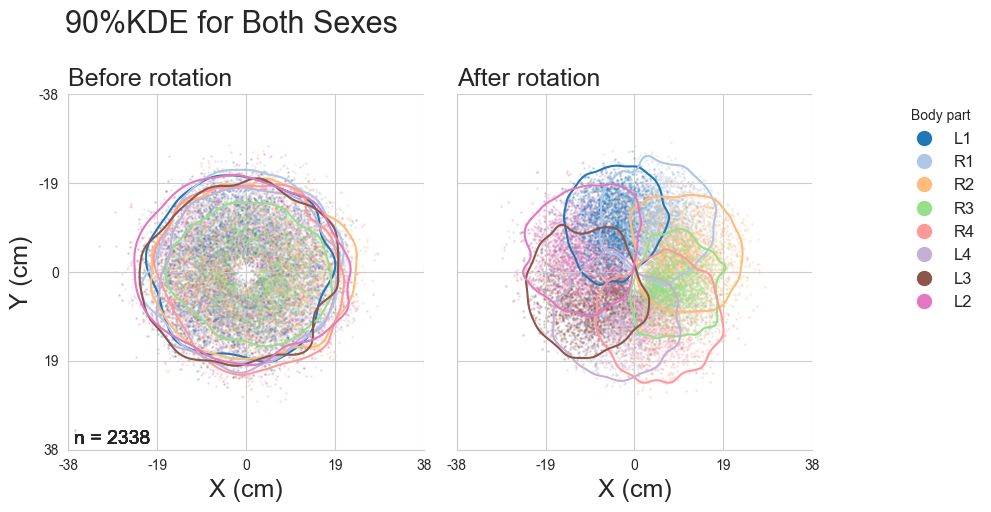

In [161]:
nF = len(df[df['sex'] == 'F'])
nM = len(df[df['sex'] == 'M'])

mex = (df['lefteye_x'] + df['righteye_x'])/2
mey = (df['lefteye_y'] + df['righteye_y'])/2

for col in df.columns[4:]:
    if 'x' in col:
        c = df[col] - mex
    elif 'y' in col:
        c = df[col] - mey
    df[col] = c

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point
    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

pthresh = .99 ## threshold for dropping DLC coordinates beneath a model confidence of .99
r = 300
nbins = 300j ## number of bins for calculating the kernel density, more equals better resolution but slower.
ss = 1 ## sub sample parameter if you want it to go faster for trouble shooting
GaussKernel = 0.3 ## Kernel size for the gaussian blur (fixed for between animal comparison)

plotKthresh = 0.9 ## Kernel density threshold. 0.9 -> 90% KDE contour, Contour contains 90% of arm tip predictions

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,10))

## Find the Angle between the center (0,0) of the center eyes, and the right eye
## this is the body angle, we just have to add 90 degrees to it to make it correct
bda = np.arctan2(df['righteye_x'], df['righteye_y']) ##

norm = mpl.colors.Normalize(vmin = 0, vmax = len(df.columns[4::2]))
cmap = cm.get_cmap('tab20')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

legend_lines = []
legend_labels = []
for j, col in enumerate(df.columns[10::2]):
    col = col[:-2]
    c = m.to_rgba(j)
    legend_lines.append(Line2D([0], [0], color=c, marker='o', markersize=10, lw=0))
    legend_labels.append(col.split('_')[0].capitalize())

pbar = tqdm(total = len(df.columns[10::2]), position=0, leave=True)
for i, col in enumerate(df.columns[10::2]):

    order = 0
    if i < 4:
        order=1

    c = m.to_rgba(i)

    x = df[col]
    y = df[col[:-2] + '_y']
    ax=ax1
    ax.scatter(x,y,color=c,s=1,alpha=0.2,zorder=order)

    g = sns.kdeplot(x=x, y=y, levels=1,
                    thresh=1-plotKthresh, color=c,
                    alpha=1, ax=ax, weights=GaussKernel, zorder=3)

    ax.set_aspect('equal')
    ax.set_xlim(-300, 300)
    ax.set_ylim(300, -300)
    ax.set_title('Before rotation', fontsize=18, loc='left')
    ax.set_ylabel('Y (cm)', fontsize=18)
    ax.set_xlabel('X (cm)', fontsize=18)

    rot_xy = [rotate((0,0), (s,z), angle - np.pi/2) for s,z,angle in zip(x,y,bda)]
    xr = [s[0] for s in rot_xy]
    yr = [s[1] for s in rot_xy]

    ticks = np.array([-300, -150, 0, 150, 300])
    tick_labels = np.round(ticks/20 * 2.54).astype('int')
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)

    ax.text(-290, 290, f'n = {nF + nM}', fontsize=14)

    ax=ax2
    ax.scatter(xr,yr,color=c,s=1,alpha=0.2,zorder=order)

    g = sns.kdeplot(x=xr, y=yr, levels=1,
                    thresh=1-plotKthresh, color=c,
                    alpha=1, ax=ax, weights=GaussKernel, zorder=3)

    ax.set_aspect('equal')
    ax.set_xlim(-300, 300)
    ax.set_ylim(300, -300)
    ax.set_xlabel('X (cm)', fontsize=18)
    ax.set_ylabel('')
    ax.set_title('After rotation', fontsize=18, loc='left')

    df[col] = xr
    df[col[:-2] + '_y'] = yr

    ticks = np.array([-300, -150, 0, 150, 300])
    tick_labels = np.round(ticks/20 * 2.54).astype('int')
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(['' for s in ticks])
    ax.set_xticklabels(tick_labels)

    pbar.update(n=1)
pbar.close()

ax=ax2
ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.5,1),
           frameon=False, fontsize=12, title='Body part')

fig.suptitle(f'90%KDE for Both Sexes', fontsize=22, horizontalalignment='left', y=.74, x=.07)

fig.tight_layout()

fig_name = os.path.join(target_dir, r'show_effect_of_rotation_kdes_male_to_female.png')
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

/var/folders/_h/9ln9vcxs5cnbtrz_s6b7zzf00000gn/T/ipykernel_6276/2795203247.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('nipy_spectral')
100%|██████████| 8/8 [00:38<00:00,  4.81s/it]


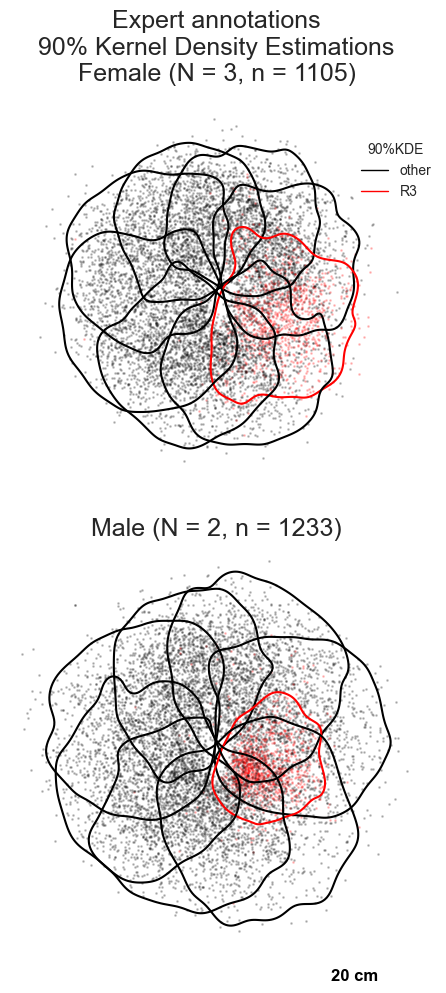

In [162]:
scale_bar_length_cm = 20
scale_bar_length_px = scale_bar_length_cm/2.54 * 20
sx0 = 80
sx1 = sx0 + scale_bar_length_px
sy0 = r - 15
sy1 = sy0
scale_bar_text = f'{scale_bar_length_cm} cm'
stx = sx0 + (sx1-sx0)/2 - (scale_bar_length_px/6)
sty = sy0 - 17.5

pthresh = .99 ## threshold for dropping DLC coordinates beneath a model confidence of .99
r = 240
nbins = 300j ## number of bins for calculating the kernel density, more equals better resolution but slower.
ss = 1 ## sub sample parameter if you want it to go faster for trouble shooting
GaussKernel = 0.3 ## Kernel size for the gaussian blur (fixed for between animal comparison)
plotKthresh = 0.9 ## Kernel density threshold. 0.9 -> 90% KDE contour, Contour contains 90% of arm tip predictions
thresh = 1-plotKthresh ## for calculating the area we take the inverse of the plot threshold

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(5,10))

norm = mpl.colors.Normalize(vmin = 0, vmax = len(df.columns[4::2]))
cmap = cm.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)

legend_lines = []
legend_labels = []
for j, col in enumerate(df.columns[10::2]):
    col = col[:-2]
    c = m.to_rgba(j)
    legend_lines.append(Line2D([0], [0], color=c, marker='o', markersize=10, lw=0))
    legend_labels.append(col.split('_')[0].capitalize())

df_kde = {'sex':[], 'bodypart':[], 'kde':[], 'kde_area':[]}

pbar = tqdm(total = len(df.columns[10::2]), position=0, leave=True)
for i, col in enumerate(df.columns[10::2]):

    order = 0
    #if i < 3:
    #    order=1

    c='black'
    if 'r3' in col:
      c='red'
    #c = m.to_rgba(i)

    ## male ##
    dfm = df[df['sex'] == 'M']
    x = dfm[col]
    y = dfm[col[:-2] + '_y']

    if order==0:
        X, Y = np.mgrid[-r:r:nbins,
                        -r:r:nbins]
        positions = np.vstack([X.ravel(),
                               Y.ravel()])
        x_nan, y_nan = np.isnan(x).tolist(), np.isnan(y).tolist()
        x_new, y_new = [], []

        j = 0
        for xs, ys in zip(x,y):
            if x_nan[j] == False and y_nan[j] == False:
                x_new.append(xs)
                y_new.append(ys)
            j += 1
        x_new, y_new = np.array(x_new), np.array(y_new)
        values = np.vstack([x_new,y_new])
        kernel = stats.gaussian_kde(values, GaussKernel,)
        Z = np.reshape(kernel(positions).T, X.shape)
        f = np.reshape(kernel(positions).T, X.shape)
        Z = np.rot90(Z)

        Zs = (Z - Z.min())/(Z.max() - Z.min())
        Z_area = np.sum(np.where(Zs > thresh, 1, 0))

        df_kde['sex'].append('M')
        df_kde['bodypart'].append(col[:-2])
        df_kde['kde'].append(Z)
        df_kde['kde_area'].append(Z_area)

    ax=ax2
    ax.scatter(x,y,color=c,s=1,alpha=0.2,zorder=order)

    if order==0:
        ord = 3
        if 'r3' in col:
          ord = 4
        g = sns.kdeplot(x=x, y=y, levels=1,
                        thresh=1-plotKthresh, color=c,
                        alpha=1, ax=ax, weights=GaussKernel, zorder=3)

    ## female ##
    dff = df[df['sex'] == 'F']
    x = dff[col]
    y = dff[col[:-2] + '_y']
    if order==0:
        X, Y = np.mgrid[-r:r:nbins,
                        -r:r:nbins]
        positions = np.vstack([X.ravel(),
                               Y.ravel()])
        x_nan, y_nan = np.isnan(x).tolist(), np.isnan(y).tolist()
        x_new, y_new = [], []

        j = 0
        for xs, ys in zip(x,y):
            if x_nan[j] == False and y_nan[j] == False:
                x_new.append(xs)
                y_new.append(ys)
            j += 1
        x_new, y_new = np.array(x_new), np.array(y_new)
        values = np.vstack([x_new,y_new])
        kernel = stats.gaussian_kde(values, GaussKernel,)
        Z = np.reshape(kernel(positions).T, X.shape)
        f = np.reshape(kernel(positions).T, X.shape)
        Z = np.rot90(Z)

        Zs = (Z - Z.min())/(Z.max() - Z.min())
        Z_area = np.sum(np.where(Zs > thresh, 1, 0))

        df_kde['sex'].append('F')
        df_kde['bodypart'].append(col[:-2])
        df_kde['kde'].append(Z)
        df_kde['kde_area'].append(Z_area)

    ax=ax1
    ax.scatter(x,y,color=c,s=1,alpha=0.2,zorder=order)

    if order==0:
        ord = 3
        if 'r3' in col:
          ord = 4
        g = sns.kdeplot(x=x, y=y, levels=1,
                        thresh=1-plotKthresh, color=c,
                        alpha=1, ax=ax, weights=GaussKernel, zorder=3)

    pbar.update(n=1)
pbar.close()

ax=ax1
for spine in ax.spines.values():
        spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(None)
ax.set_aspect('equal')

ax.set_xlim(-r, r)
ax.set_ylim(r, -r)

legend_lines = []
legend_labels = []
legend_lines.append(Line2D([0], [0], color='black', lw=1))
legend_labels.append(f'other')
legend_lines.append(Line2D([0], [0], color='red', lw=1))
legend_labels.append(f'R3')

ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.05,.9),
           frameon=False, fontsize=10, title='90%KDE')

ax.set_title(f'Expert annotations\n90% Kernel Density Estimations\nFemale (N = 3, n = {nF})', fontsize=18, loc='center')
ax=ax2
#ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.5,1),
#           frameon=False, fontsize=12, title='Body part')

for spine in ax.spines.values():
        spine.set_visible(False)
ax.set_xticks([])
ax.set_yticks([])

ax.plot([sx0, sx1], [sy0, sy1], color='black', linewidth=3, alpha=1)
ax.text(stx, sty, scale_bar_text, color='black', fontweight='bold',
        fontsize=12)
ax.set_xlabel('')
ax.set_ylabel('')
ax.grid(None)
ax.set_aspect('equal')

ax.set_xlim(-r, r)
ax.set_ylim(r, -r)
ax.set_title(f'Male (N = 2, n = {nM})', fontsize=18, loc='center')

fig.tight_layout(w_pad=-1)

fig_name = os.path.join(target_dir,'comparing_kdes_male_to_female.png')
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [163]:
df_kde = pd.DataFrame(df_kde)
## converting to cm^2
a = np.array(df_kde['kde_area'])
a = a*(1/(20**2))
a = a*((2.54**2))
df_kde['kde_area_cm2'] = a

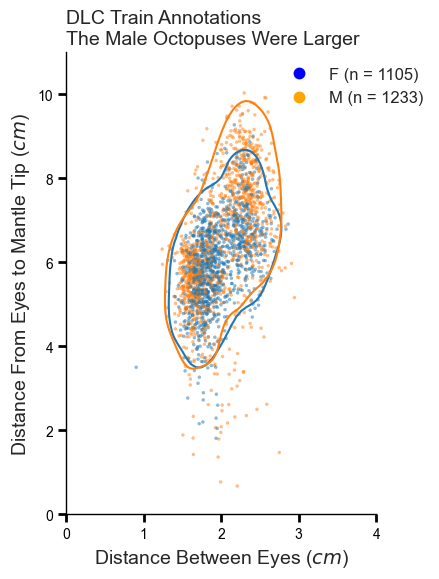

In [164]:
fig, (ax1) = plt.subplots(1,1,figsize=(4,6))

D_eyes = ((df['lefteye_x']-df['righteye_x'])**2+(df['lefteye_y']-df['righteye_y'])**2)**(1/2)
D_eyes = D_eyes/20 * 2.54 ## converting to cm
df['Distance_between_eyes_cm'] = D_eyes
D_mt = ((0-df['mantle_tip_x'])**2+(0-df['mantle_tip_y'])**2)**(1/2) ## everything is already centered
D_mt = D_mt/20 * 2.54 ## converting to cm
df['Distance_eyes_to_mantle_tip_cm'] = D_mt

ax=ax1
g0 = sns.scatterplot(y='Distance_eyes_to_mantle_tip_cm',x='Distance_between_eyes_cm',
                hue='sex', ax=ax,data=df, s=5,alpha=.5, edgecolors=None, legend=False)
g1 = sns.kdeplot(x='Distance_between_eyes_cm', y='Distance_eyes_to_mantle_tip_cm',
                hue='sex', levels=1, data=df,thresh=1-plotKthresh, color=c,
                        alpha=1, ax=ax, weights=GaussKernel, zorder=3, legend=False)

ax.set_xlim(0,4)
ax.set_ylim(0,11)
ax.set_xlabel('Distance Between Eyes ($cm$)', fontsize=14)
ax.set_ylabel('Distance From Eyes to Mantle Tip ($cm$)', fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(None)

legend_lines = [Line2D([0], [0], color='blue', lw = 0, marker='.', markersize=15),
                Line2D([0], [0], color='orange', lw = 0, marker='.', markersize=15)]
legend_labels = [f'F (n = {nF})', f'M (n = {nM})']
ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.2, 1),
           frameon=False, fontsize=12, title=False)

ax.set_title(f'DLC Train Annotations\nThe Male Octopuses Were Larger', loc='left', fontsize=14)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

fig_name = os.path.join(target_dir,'comparing_sex_eye_and_mantle_size.png')
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [165]:
tips = ['l4_tip', 'l3_tip', 'l2_tip', 'l1_tip',
       'r1_tip', 'r2_tip', 'r3_tip', 'r4_tip']
for tip in tips:
    x = df[tip + '_x']
    y = df[tip + '_y']
    D = ((0-x)**2+(0-y)**2)**(1/2) ## everything is already centered of the eyes
    D = D/20 * 2.54 ## converting to cm
    df[tip+'_D_cm'] = D

In [166]:
ans = []
sexes = []
armtips = []
coords = []

pbar = tqdm(total=df.shape[0], position=0, leave=True)
for row in df.values[0:]:
    an = row[1]
    sex = row[2]
    for c, col in zip(row[-8:], df.columns[-8:]):
        ans.append(an)
        sexes.append(sex)
        armtips.append(col[:6])
        coords.append(c)
    pbar.update(n=1)
pbar.close()

dat = pd.DataFrame(list(zip(ans, sexes, armtips, coords)),
                  columns = ['Animal', 'Sex', 'Arm_tip', 'Distance_to_Arm_Tip_CM'])

100%|██████████| 2338/2338 [00:00<00:00, 86682.31it/s]


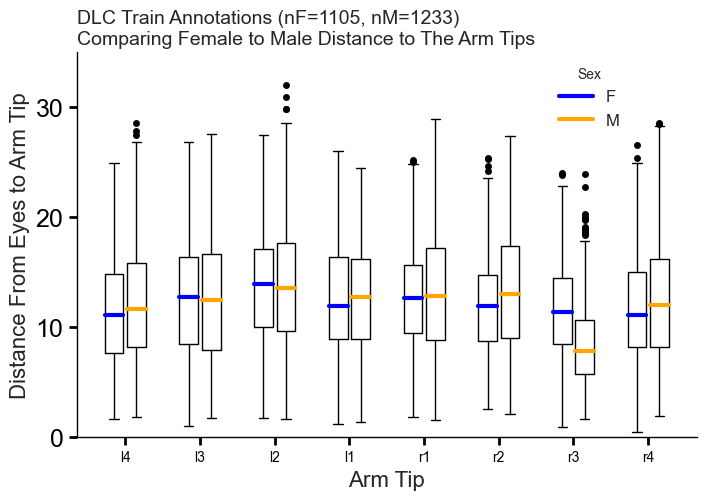

In [167]:
fig, (ax1) = plt.subplots(1,1,figsize=(8,5))

pos_shift = .15
widths = [.25]
ax=ax1

xticks = []
xlabs = []
for i, tip in enumerate(tips):
    xticks.append(i)
    xlabs.append(tip.split('_')[0])
    for sex in ['F', 'M']:
        D = df[df['sex'] == sex][tip + '_D_cm']
        D = D[~np.isnan(D)]

        if sex == 'F':
            pos = [i-pos_shift]
            flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
            medianprops = dict(linestyle='-', linewidth=3, color='blue')
            boxprops = dict(linestyle='-', linewidth=1, color='black')

        elif sex == 'M':
            pos = [i+pos_shift]
            flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
            medianprops = dict(linestyle='-', linewidth=3, color='orange')
            boxprops = dict(linestyle='-', linewidth=1, color='black')

        ax.boxplot(D, positions = pos, widths=widths,
                  flierprops=flierprops,
                  medianprops=medianprops,
                  boxprops=boxprops)

ax.set_xticks(xticks)
ax.set_xticklabels(xlabs, fontsize=18)
ax.set_xlabel('Arm Tip', fontsize=16)

ax.set_ylabel('Distance From Eyes to Arm Tip', fontsize=16)

ax.set_ylim(0, 35)
yticks = [0, 10, 20, 30]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=18)

ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)


legend_lines = [Line2D([0], [0], color='blue', lw=3),
                Line2D([0], [0], color='orange', lw=3)]
legend_labels = ['F', 'M']

ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (.9,1),
           frameon=False, fontsize=12, title='Sex')

ax.set_title(f'DLC Train Annotations (nF={nF}, nM={nM})\nComparing Female to Male Distance to The Arm Tips',
            loc='left', fontsize=14)

fig_name = os.path.join(target_dir,'comparing_sex_arm_tip_distance_size.png')
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [168]:
model = ols(r'Distance_to_Arm_Tip_CM ~ C(Sex) + C(Arm_tip) + C(Sex):C(Arm_tip)',
            data=dat).fit()
f = sm.stats.anova_lm(model, test='F', typ=2, robust='hc3')
round(f,5)

sum_sq       df          F   PR(>F)
C(Sex)                 79.10947      1.0    3.15678  0.07563
C(Arm_tip)          29413.77961      7.0  167.67526  0.00000
C(Sex):C(Arm_tip)   10004.42820      7.0   57.03092  0.00000
Residual           445820.22319  17790.0        NaN      NaN

In [169]:
model = ols(r'Distance_to_Arm_Tip_CM ~ C(Sex) + C(Arm_tip) + C(Animal) + C(Sex):C(Arm_tip)',
            data=dat).fit()
f = sm.stats.anova_lm(model, test='F', typ=2, robust='hc3')
f

/Users/wlweert/opt/anaconda3/envs/hold-it-close/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 4, but rank is 1
  warnings.warn('covariance of constraints does not have full '


sum_sq       df             F  PR(>F)
C(Sex)             4.067178e+15      1.0  1.819488e+14     0.0
C(Arm_tip)         4.091303e+17      7.0  2.614686e+15     0.0
C(Animal)          1.660532e+16      4.0  1.857134e+14     0.0
C(Sex):C(Arm_tip)  9.923782e+16      7.0  6.342130e+14     0.0
Residual           3.975780e+05  17786.0           NaN     NaN

In [170]:
model = ols(r'Distance_to_Arm_Tip_CM ~ C(Arm_tip) + C(Animal) + C(Animal):C(Arm_tip)',
            data=dat).fit()
f = sm.stats.anova_lm(model, test='F', typ=2, robust='hc3')
f

sum_sq       df           F         PR(>F)
C(Arm_tip)             28530.921175      7.0  186.942941  1.826914e-268
C(Animal)              55542.105306      4.0  636.874211   0.000000e+00
C(Animal):C(Arm_tip)   24787.289046     28.0   40.603392  2.425586e-214
Residual              387345.344339  17766.0         NaN            NaN

In [171]:
def get_p_symbol(p, alpha=0.05):
    if p > alpha + 0.05:
        return 'ns'
    elif p > alpha:
        return '.'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p > 0.0001:
        return '***'
    else:
        return '****'

Ttest_indResult(statistic=18.27491097373964, pvalue=1.2035315783502243e-69)


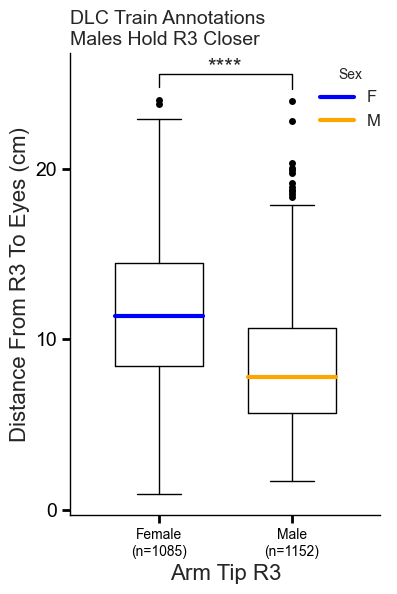

In [172]:
datn = dat[dat['Arm_tip'] == 'r3_tip']

fig, (ax1) = plt.subplots(1,1,figsize=(4,6))

ax=ax1

F = datn[datn['Sex'] == 'F']['Distance_to_Arm_Tip_CM']
F = F[~np.isnan(F)]
M = datn[datn['Sex'] == 'M']['Distance_to_Arm_Tip_CM']
M = M[~np.isnan(M)]
out = stats.ttest_ind(F,M)
print(out)

pos = [0, .75]

flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color='black')

ax.boxplot(F, positions=[pos[0]], widths=[.5],
            flierprops=flierprops,
            medianprops=medianprops,
            boxprops=boxprops)

flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color='black')

ax.boxplot(M, positions=[pos[1]], widths=[.5],
           flierprops=flierprops,
           medianprops=medianprops,
           boxprops=boxprops)

ax.set_xticks(pos)
ax.set_xticklabels([f'Female\n(n={len(F)})', f'Male\n(n={len(M)})'], fontsize=14)
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels([0,10,20,30], fontsize=14)
ax.set_ylabel('Distance From R3 To Eyes (cm)', fontsize=16)
ax.set_xlabel('Arm Tip R3', fontsize=16)

xpos = [pos[0], pos[0], pos[1], pos[1]]
ysh = .75
ypos = [np.max(F)+ysh, np.max(F)+2*ysh, np.max(F)+2*ysh, np.max(M)+ysh]
ax.plot(xpos, ypos, color='black', linewidth=1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.05,1),
           frameon=False, fontsize=12, title='Sex')

psym = get_p_symbol(out.pvalue)

ax.text((xpos[1]+xpos[2])/2-.1, np.max(F)+2*ysh+.05, psym, fontsize=16)

ax.set_title('DLC Train Annotations\nMales Hold R3 Closer', fontsize=14, loc='left')

ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)


fig_name = os.path.join(target_dir,'comparing_sex_R3_arm_tip_distance.png')
fig.savefig(fig_name, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [173]:
dat = dat.dropna()
dat = dat[dat['Distance_to_Arm_Tip_CM'] < 33]

Comparing Normalized Means of Arm-tip Distance from the Eyes
	Female, Front to Back: t(4351,3174) = T(7.232684779254278); p = 5.201730526996092e-13
	Female, R3 to Front: t(1084,3174) = T(-7.32698995669985); p = 2.698256961687881e-13
	Female, R3 to Back: t(1084,4351) = T(-2.0406131171463344); p = 0.0413508526231579
	Male, Front to Back: t(4684,3354) = T(5.8562167369369265); p = 4.921565840794459e-09
	Male, R3 to Front: t(1151,3354) = T(-28.17634934523133); p = 7.025015433394893e-164
	Male, R3 to Back: t(1151,4684) = T(-23.251289647793666); p = 4.912776146444578e-113


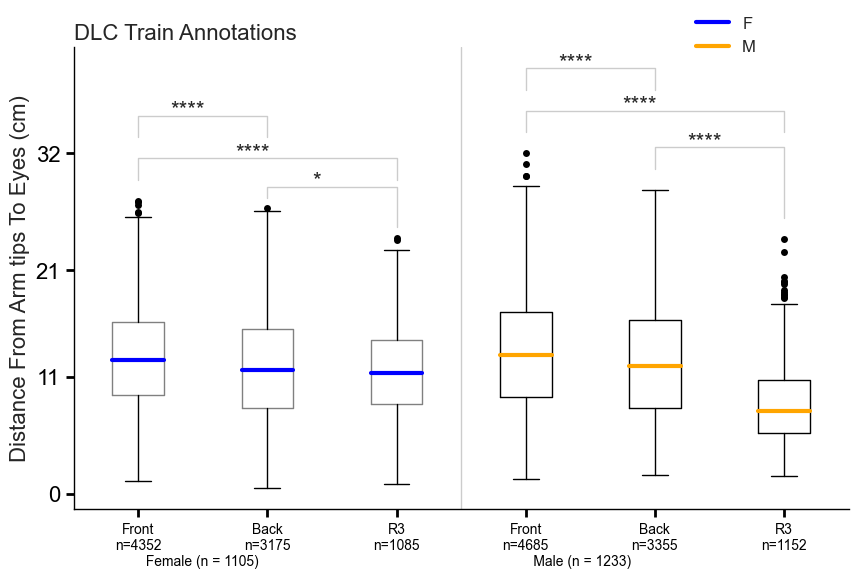

In [174]:
fig, (ax1) = plt.subplots(1,1,figsize=(10,6))

dat_r3 = dat[dat['Arm_tip'] == 'r3_tip']
dat_front = dat[(dat['Arm_tip'] == 'l2_tip') | (dat['Arm_tip'] == 'l1_tip') | (dat['Arm_tip'] == 'r1_tip') | (dat['Arm_tip'] == 'r2_tip')]
dat_back = dat[(dat['Arm_tip'] == 'l4_tip') | (dat['Arm_tip'] == 'l3_tip') | (dat['Arm_tip'] == 'r4_tip')]

print('Comparing Normalized Means of Arm-tip Distance from the Eyes')

## Dist ##
# Female #
r3_f = np.array(dat_r3[dat_r3['Sex'] == 'F']['Distance_to_Arm_Tip_CM'].tolist())
r3_front_f = np.array(dat_front[dat_front['Sex'] == 'F']['Distance_to_Arm_Tip_CM'].tolist())
r3_back_f = np.array(dat_back[dat_back['Sex'] == 'F']['Distance_to_Arm_Tip_CM'].tolist())
f_r3_to_back = stats.ttest_ind(r3_f, r3_back_f)
f_r3_to_front = stats.ttest_ind(r3_f, r3_front_f)
f_front_to_back = stats.ttest_ind(r3_front_f, r3_back_f)

print(f'\tFemale, Front to Back: t({len(r3_front_f)-1},{len(r3_back_f)-1}) = T({f_front_to_back.statistic}); p = {f_front_to_back.pvalue}')
print(f'\tFemale, R3 to Front: t({len(r3_f)-1},{len(r3_back_f)-1}) = T({f_r3_to_front.statistic}); p = {f_r3_to_front.pvalue}')
print(f'\tFemale, R3 to Back: t({len(r3_f)-1},{len(r3_front_f)-1}) = T({f_r3_to_back .statistic}); p = {f_r3_to_back .pvalue}')

# Male #
r3_m = np.array(dat_r3[dat_r3['Sex'] == 'M']['Distance_to_Arm_Tip_CM'].tolist())
r3_front_m = np.array(dat_front[dat_front['Sex'] == 'M']['Distance_to_Arm_Tip_CM'].tolist())
r3_back_m = np.array(dat_back[dat_back['Sex'] == 'M']['Distance_to_Arm_Tip_CM'].tolist())
m_r3_to_back = stats.ttest_ind(r3_m, r3_back_m)
m_r3_to_front = stats.ttest_ind(r3_m, r3_front_m)
m_front_to_back = stats.ttest_ind(r3_front_m, r3_back_m)

print(f'\tMale, Front to Back: t({len(r3_front_m)-1},{len(r3_back_m)-1}) = T({m_front_to_back.statistic}); p = {m_front_to_back.pvalue}')
print(f'\tMale, R3 to Front: t({len(r3_m)-1},{len(r3_back_m)-1}) = T({m_r3_to_front.statistic}); p = {m_r3_to_front.pvalue}')
print(f'\tMale, R3 to Back: t({len(r3_m)-1},{len(r3_front_m)-1}) = T({m_r3_to_back .statistic}); p = {m_r3_to_back .pvalue}')

# plotting #
ax=ax1
# params #
pos = [0, 1, 2, 3, 4, 5]
wds = [.4]*6
xticks = pos
xlabs = [f'Front\nn={r3_front_m.shape[0]}\n                             Male (n = {nM})', f'Back\nn={r3_back_m.shape[0]}',
         f'R3\nn={r3_m.shape[0]}', f'Front\nn={r3_front_f.shape[0]}\n                                 Female (n = {nF})',
         f'Back\nn={r3_back_f.shape[0]}', f'R3\nn={r3_f.shape[0]}']
xlabs = xlabs[3:] + xlabs[:3]

yticks = np.arange(0, np.max(dat['Distance_to_Arm_Tip_CM']) +  np.max(dat['Distance_to_Arm_Tip_CM'])/3, np.max(dat['Distance_to_Arm_Tip_CM'])/3)
yticks = np.round(yticks).astype('int')
ylabs = yticks
ax.tick_params(bottom=True, left=True)

# male #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color='black')
ax.boxplot([r3_front_m, r3_back_m, r3_m], positions = pos[3:], widths = wds[3:],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
# Female #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color='grey')
ax.boxplot([r3_front_f, r3_back_f, r3_f], positions = pos[:3], widths = wds[:3],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)

# plot settings #
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs,fontsize=16)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabs,fontsize=16)
ax.axvline(x=(pos[3]+pos[2])/2, color='black', linewidth=1, alpha=0.2)
ax.set_ylabel('Distance From Arm tips To Eyes (cm)',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('DLC Train Annotations', loc='left', fontsize=16)

# draw comparison lines #
# Male #
# front to back #
b = 3
h = 2
sh = 4
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 4
sh = 0
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_m)+h+sh, max(r3_back_m)+h+h+sh, max(r3_back_m)+h+h+sh, max(r3_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 3
sh = 0.01
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

# Female #
# front to back #
b = 0
h = 2
sh = 4
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 1
h = 1
sh = 0
th = .01
tb = -.15
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_f)+h+sh, max(r3_back_f)+h+h+sh, max(r3_back_f)+h+h+sh, max(r3_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 0
h = 2
sh = 0.01
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (.9,1.1),
           frameon=False, fontsize=12, title=False)

ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)


fig_name = os.path.join(target_dir,'dlc_annotations_full_male-to-female-comparison.png')
path_fig = os.path.join(fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

In [175]:
dat_annos = dat.copy()
df_annos = df.copy()

In [176]:
path_df = '../DATA/dlc_inference/unrotated_tips.csv'
if os.path.exists(path_df) != True:
    print(f'{path_df} does not exist!')
else:
    df = pd.read_csv(path_df)

In [177]:
df

lefteye_x   lefteye_y  lefteye_p   righteye_x  righteye_y  \
0        611.271149  223.172882   0.999639   624.998474  219.606537   
1        613.597748  232.471863   0.999642   626.504272  227.717285   
2        620.184021  241.892029   0.998512   628.179047  236.180817   
3        629.110138  254.613464   0.987928   628.701996  247.585175   
4        630.303040  241.768127   0.551609   630.015259  227.367264   
...             ...         ...        ...          ...         ...   
440170  1146.789490  228.976379   1.000000  1159.447601  225.373871   
440171  1143.775238  224.711456   1.000000  1156.642120  221.979126   
440172  1141.019440  222.750244   1.000000  1152.798645  219.465302   
440173  1139.058594  222.626892   1.000000  1150.488647  219.173187   
440174  1136.516357  222.268677   1.000000  1148.808472  219.456360   

        righteye_p  mantle_tip_x  mantle_tip_y  mantle_tip_p     l1_tip_x  \
0         0.998700    633.498077    287.006592      0.999813   591.315079   
1         0.994357    635.599121    295.638885      0.999930   591.315079   
2         0.986206    633.762360    307.768707      0.999568   574.442429   
3         0.842734    633.924347    319.128967      0.996190   568.879990   
4         0.949737    634.264085    282.339846      0.068275   576.551066   
...            ...           ...           ...           ...          ...   
440170    1.000000   1160.714752    262.761322      1.000000  1104.742767   
440171    1.000000   1158.347565    260.412933      1.000000  1103.553680   
440172    1.000000   1157.530792    258.263763      0.999998  1099.419952   
440173    1.000000   1152.175903    255.251404      1.000000  1098.083710   
440174    1.000000   1148.467072    254.637421      1.000000  1094.953308   

        ...    l3_tip_y  l3_tip_p     l2_tip_x    l2_tip_y  l2_tip_p  \
0       ...  272.168457  0.999814   639.411212  346.709308  0.990198   
1       ...  274.135651  0.999982   639.411212  346.709308  0.990198   
2       ...  292.180716  0.999134   639.411212  346.709308  0.990198   
3       ...  313.375092  0.956943   639.411212  346.709308  0.990198   
4       ...  339.491333  0.746086   647.432902  379.725881  0.854501   
...     ...         ...       ...          ...         ...       ...   
440170  ...  308.223175  0.999964  1038.868240  217.320129  1.000000   
440171  ...  311.986786  0.999993  1018.463196  206.799744  0.999983   
440172  ...  318.517731  0.999981  1018.091171  205.964142  0.999515   
440173  ...  319.112762  0.999989  1014.048431  205.995209  0.999949   
440174  ...  319.310455  0.999990  1008.537827  206.748291  0.999779   

        Animal ID                     Root  Index    Meaneye_x   Meaneye_y  
0             jos           joseph-14_50-9      0   618.134811  221.389709  
1             jos           joseph-14_50-9      1   620.051010  230.094574  
2             jos           joseph-14_50-9      2   624.181534  239.036423  
3             jos           joseph-14_50-9      3   628.906067  251.099319  
4             jos           joseph-14_50-9      4   630.159149  234.567696  
...           ...                      ...    ...          ...         ...  
440170        sla  slaanesh_9_9_100_eat_01   2551  1153.118546  227.175125  
440171        sla  slaanesh_9_9_100_eat_01   2552  1150.208679  223.345291  
440172        sla  slaanesh_9_9_100_eat_01   2553  1146.909042  221.107773  
440173        sla  slaanesh_9_9_100_eat_01   2554  1144.773621  220.900040  
440174        sla  slaanesh_9_9_100_eat_01   2555  1142.662415  220.862518  

[440175 rows x 38 columns]

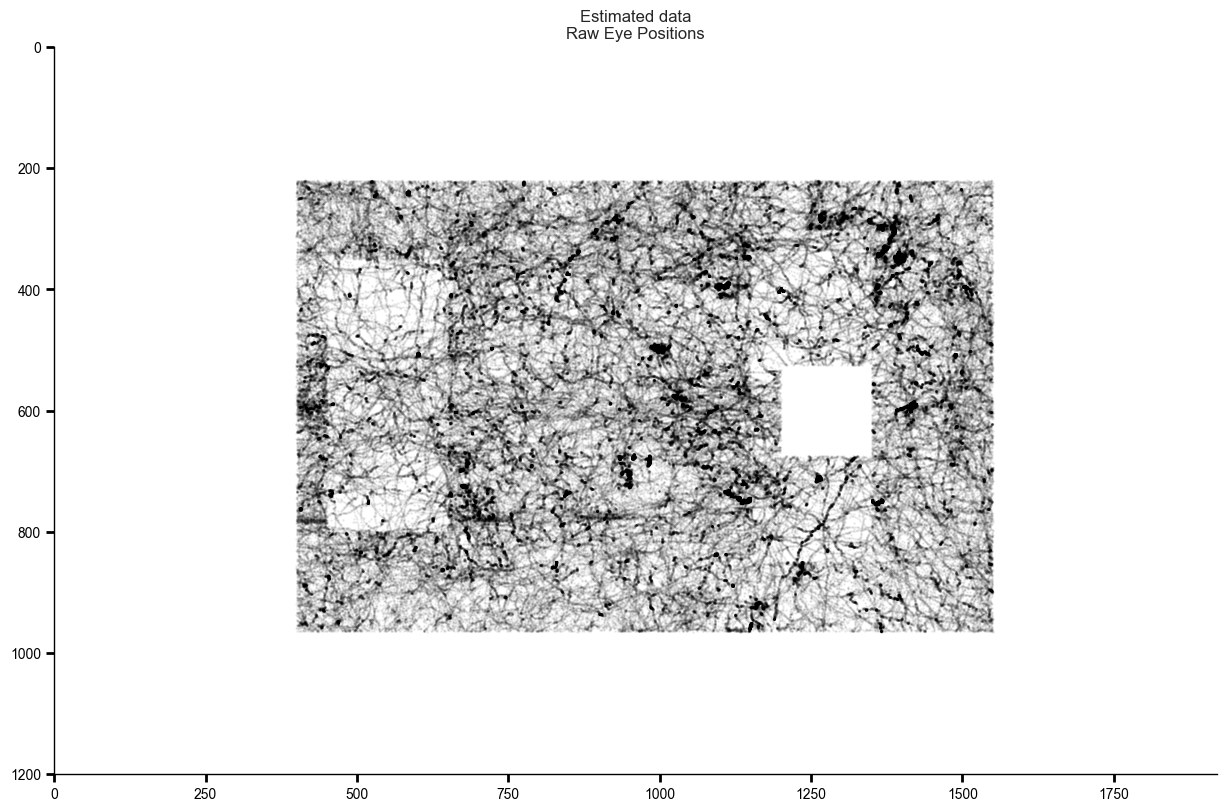

/var/folders/_h/9ln9vcxs5cnbtrz_s6b7zzf00000gn/T/ipykernel_6276/1544094762.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)
100%|██████████| 11/11 [00:29<00:00,  2.66s/it]


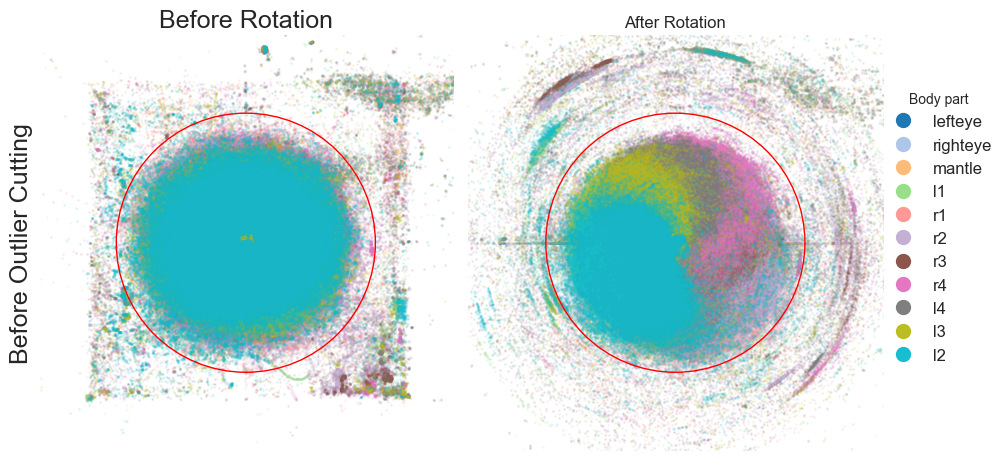

/var/folders/_h/9ln9vcxs5cnbtrz_s6b7zzf00000gn/T/ipykernel_6276/1544094762.py:167: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(colormap)
100%|██████████| 11/11 [00:27<00:00,  2.52s/it]


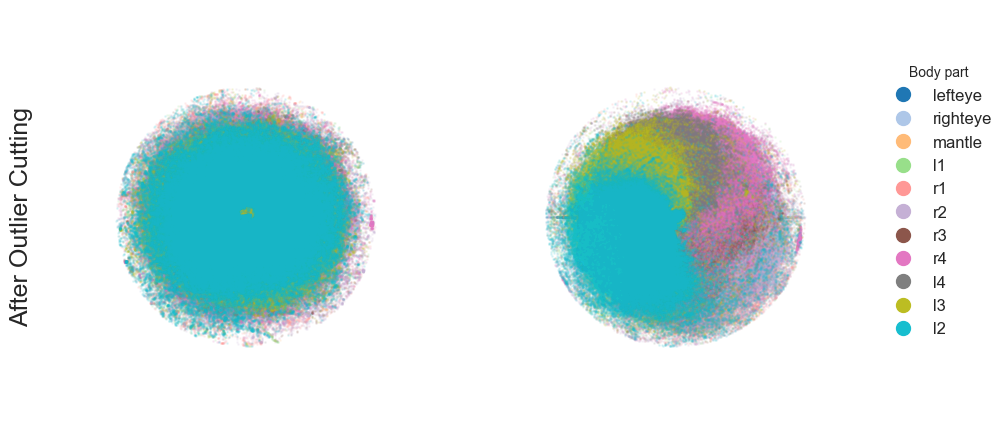

In [178]:
r = 250 ## cut off distance to get rid of outliers
ss = 1 ## sub-sample if you want it to go faster for trouble shooting
colormap = 'tab20' ## arm tip colormap

dat = df.copy()
dat = dat.iloc[::ss]

rex = np.array(dat['righteye_x'].tolist())
rey = np.array(dat['righteye_y'].tolist())

mex = np.array(dat['Meaneye_x'].tolist())
mey = np.array(dat['Meaneye_y'].tolist())

fig, (ax) = plt.subplots(1,1,figsize=(15,15))

ax.scatter(mex, mey, color='black', s=1, alpha=0.05)
ax.set_aspect('equal')
ax.set_title('Estimated data\nRaw Eye Positions')
ax.set_xlim(0, 1920)
ax.set_ylim(1200, 0)

ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

plt.show(fig)
plt.close(fig)


rex = rex-mex
rey = rey-mey

bda = np.arctan2(rex, rey)

dat['Body_Axis_angle'] = bda

cols = dat.columns[0:33].tolist()
k=3
del cols[k-1::k]
cols_x, cols_y = cols[0::2], cols[1::2]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

norm = mpl.colors.Normalize(vmin = 0, vmax = len(cols_x))
cmap = cm.get_cmap(colormap)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

legend_lines = []
legend_labels = []
for j, col in enumerate(cols_x):
  c = m.to_rgba(j)
  legend_lines.append(Line2D([0], [0], color=c, marker='o', markersize=10, lw=0))
  legend_labels.append(col.split('_')[0])

j = 0
InCirc = [True]*dat.shape[0]
pbar = tqdm(total = int(len(cols_x)), position=0, leave=True)
for xcol, ycol in list(zip(cols_x, cols_y)):
  xarr = np.array(dat[xcol].tolist())-mex
  yarr = np.array(dat[ycol].tolist())-mey

  D = (xarr**2 + yarr**2)**(1/2)
  for i, d in enumerate(D):
    if d > r:
      InCirc[i] = False

  c = m.to_rgba(j)
  ax=ax1
  ax.scatter(xarr, yarr, s=1, alpha=0.1, color=c)

  rot_xy = [rotate((0,0), (x,y), angle - np.pi/2) for x,y,angle in list(zip(xarr, yarr,bda))]
  xarr = [s[0] for s in rot_xy]
  yarr = [s[1] for s in rot_xy]

  ax=ax2
  ax.scatter(xarr, yarr, s=1, alpha=0.1, color=c)

  pbar.update(n=1)
  j += 1
pbar.close()

ax=ax1
circ = plt.Circle((0,0), r, linewidth=1, color='red', fill = False)
ax.set_aspect('equal')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.add_patch(circ)
ax.set_title('Before Rotation', fontsize=18)
ax.set_ylabel('Before Outlier Cutting', fontsize=18)

ax=ax2
circ = plt.Circle((0,0), r, linewidth=1, color='red', fill = False)
ax.set_aspect('equal')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.add_patch(circ)
ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.3,.9),
           frameon=False, fontsize=12, title='Body part')
ax.set_title('After Rotation')

ax.grid(None)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both', direction='out', length=6, width=2, colors='black',
           grid_color='black', grid_alpha=0.5, labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both', direction='out', length=6, width=2, colors='black', left=True, right=False)

fig.tight_layout()

name_fig = 'all_tips_rotated_before_circleCut.png'
path_fig = os.path.join(target_dir, name_fig)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

dat['InCircle'] = InCirc

######### re run with dropped rows #########

dat = dat[(dat['InCircle'] == True)].copy()

rex = np.array(dat['righteye_x'].tolist())
rey = np.array(dat['righteye_y'].tolist())

mex = np.array(dat['Meaneye_x'].tolist())
mey = np.array(dat['Meaneye_y'].tolist())

rex = rex-mex
rey = rey-mey

bda = np.arctan2(rex, rey)

dat['Body_Axis_angle'] = bda

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

norm = mpl.colors.Normalize(vmin = 0, vmax = len(cols_x))
cmap = cm.get_cmap(colormap)
m = cm.ScalarMappable(norm=norm, cmap=cmap)

j = 0
pbar = tqdm(total = int(len(cols_x)), position=0, leave=True)
for xcol, ycol in list(zip(cols_x, cols_y)):
  xarr = np.array(dat[xcol].tolist())-mex
  yarr = np.array(dat[ycol].tolist())-mey

  c = m.to_rgba(j)

  ax=ax1
  ax.scatter(xarr, yarr, s=1, alpha=0.1, color=c)

  rot_xy = [rotate((0,0), (x,y), angle - np.pi/2) for x,y,angle in list(zip(xarr, yarr,bda))]
  xarr = [s[0] for s in rot_xy]
  yarr = [s[1] for s in rot_xy]

  dat[xcol] = xarr
  dat[ycol] = yarr

  ax=ax2
  ax.scatter(xarr, yarr, s=1, alpha=0.1, color=c)

  j += 1
  pbar.update(n=1)
pbar.close()

ax=ax1
#circ = plt.Circle((0,0), r, linewidth=1, color='red', fill = False)
ax.set_aspect('equal')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('After Outlier Cutting', fontsize=18)
#ax.add_patch(circ)

ax=ax2
#circ = plt.Circle((0,0), r, linewidth=1, color='red', fill = False)
ax.set_aspect('equal')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.add_patch(circ)
ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (1.3,.9),
           frameon=False, fontsize=12, title='Body part')

fig.tight_layout()

name_fig = 'all_tips_rotated_after_circleCut.png'
path_fig = os.path.join(target_dir, name_fig)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [179]:
dat_inf = dat.copy()

In [180]:

fps = 10 # frames/sec
time = df.shape[0]/fps/60/60
print(f'Time recordings = {round(time,3)} hours!')

time_after = dat.shape[0]/fps/60/60
print(f'Time recordings = {round(time_after,3)} hours!')
print(f'The subsetting and outlier filter dropped {round(time_after - time,3)} hours!')

Time recordings = 12.227 hours!
Time recordings = 11.361 hours!
The subsetting and outlier filter dropped -0.866 hours!


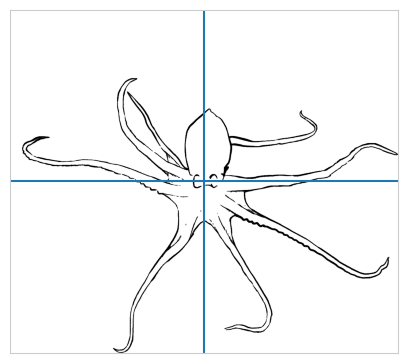

In [181]:
path_background_img = r'../DATA/diagrams/centered_image copy.png'
bg_img = cv2.imread(path_background_img)
bg_img = cv2.cvtColor(bg_img, cv2.COLOR_RGB2GRAY)

z = np.zeros([bg_img.shape[1]-bg_img.shape[0]-110, bg_img.shape[1]])
bg_img = np.vstack([z, bg_img])

z = np.zeros([bg_img.shape[0], 40])
bg_img = np.hstack([z, bg_img])

fig, (ax) = plt.subplots(1,1,figsize=(5,5))

ax.axvline(x = bg_img.shape[1]/2)
ax.axhline(y = bg_img.shape[0]/2)
ax.imshow(bg_img, cmap='Greys')
ax.set_xticks([])
ax.set_yticks([])

plt.show(fig)
plt.close(fig)

In [182]:
animals = sorted(list(set(dat['Animal ID'])))

def sort_animals (an):
  m = 'Male'
  f = 'Female'
  gender_key = {'jos':m,
              'kho':m,
              'kor':m,
              'kra':m,
              'lar':m,
              'lis':f,
              'mik':m,
              'nin':m,
              'nip':f,
              'nur':f,
              'sed':m,
              'sla':f}

  if gender_key[an] == m:
    return 1
  elif gender_key[an] == f:
    return 0
  else:
    return -1

animals = sorted(animals, key=sort_animals)

m = 'Male'
f = 'Female'
gender_key = {'jos':m,
              'kho':m,
              'kor':m,
              'kra':m,
              'lar':m,
              'lis':f,
              'mik':m,
              'nin':m,
              'nip':f,
              'nur':f,
              'sed':m,
              'sla':f}
dat['Sex'] = [gender_key[s] for s in dat['Animal ID'].tolist()]

cols = dat.columns[0:33].tolist()
k=3
del cols[k-1::k]
cols_x, cols_y = cols[0::2], cols[1::2]
cols_x = np.array(cols_x[3:])
cols_y = np.array(cols_y[3:])
cols_x = np.roll(cols_x, -5).tolist()
cols_y = np.roll(cols_y, -5).tolist()

100%|██████████| 12/12 [1:10:09<00:00, 350.82s/it]


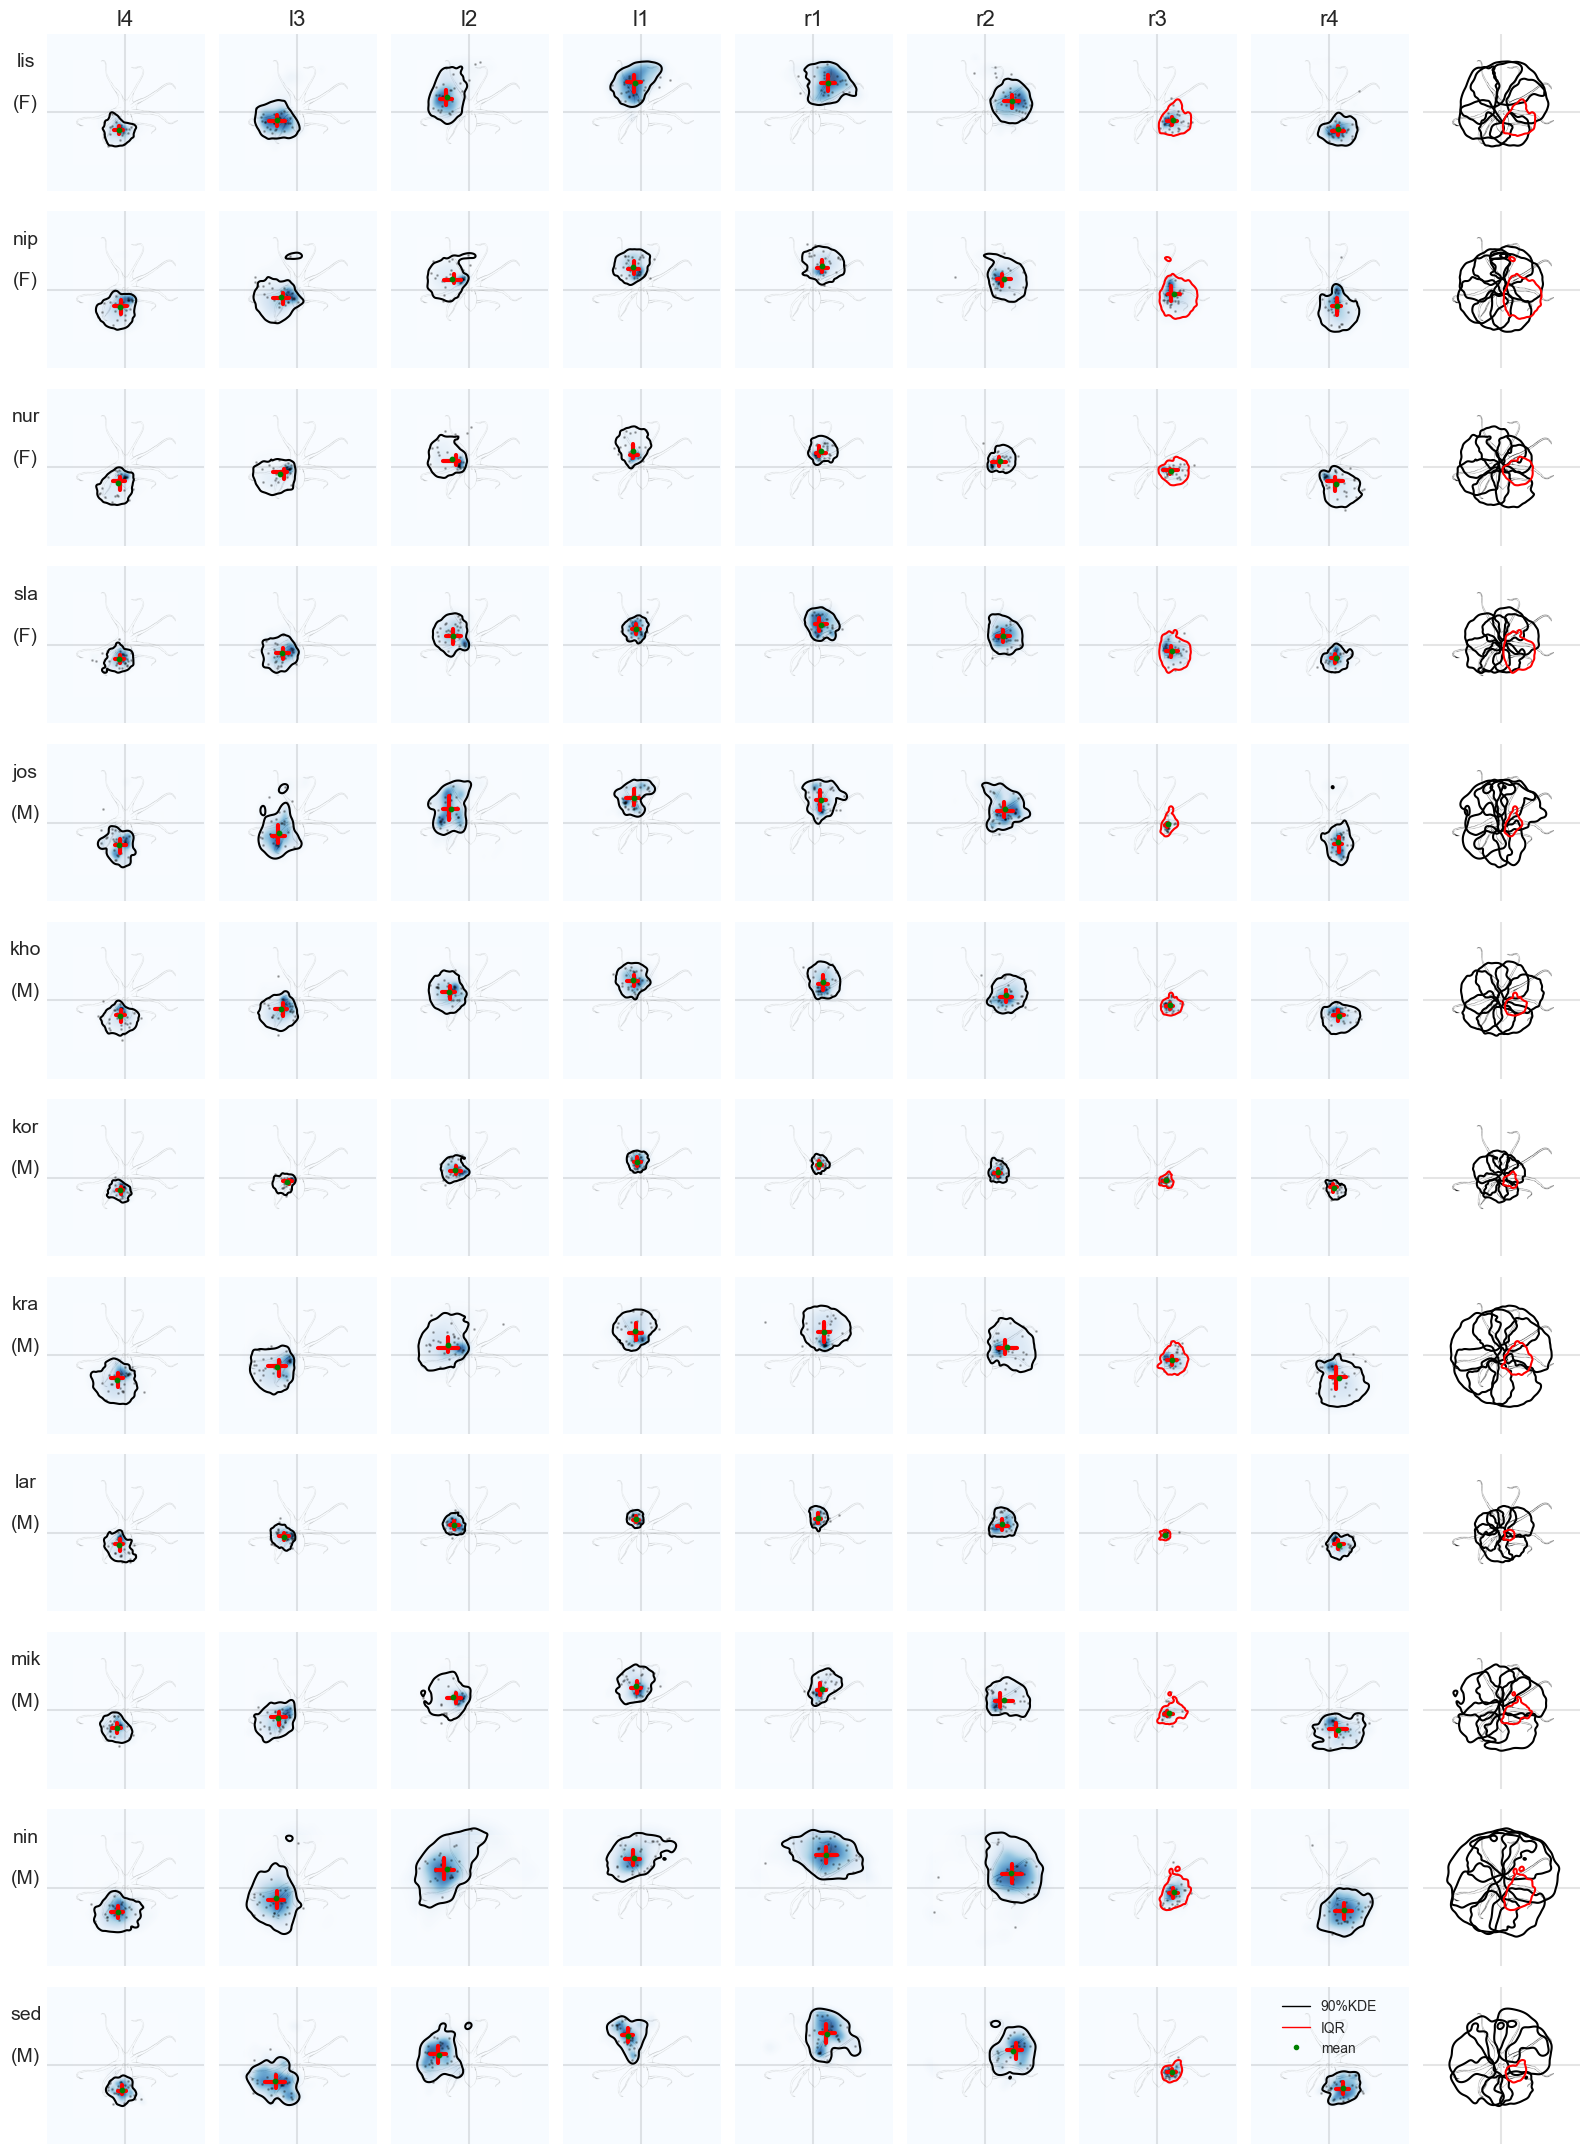

In [183]:
dcols = ['Animal ID', 'Sex', 'Body part', 'Distance Mean', 'Mean X', 'Mean Y', 'x', 'y', 'D', 'KDE']
D_Dict = {k:[] for k in dcols}

pthresh = .99 ## threshold for dropping DLC coordinates beneath a model confidence of .99
r = 300
nbins = 300j ## number of bins for calculating the kernel density, more equals better resolution but slower.
ss = 1 ## sub sample parameter if you want it to go faster for trouble shooting
GaussKernel = 0.3 ## Kernel size for the gaussian blur (fixed for between animal comparison)

plotKthresh = 0.9 ## Kernel density threshold. 0.9 -> 90% KDE contour, Contour contains 90% of arm tip predictions

ns = 30
fig, axs = plt.subplots(len(animals),9,figsize=(16,int(len(animals)*2)))

pbar = tqdm(total=len(animals), position=0, leave=True)
for i, animal in enumerate(animals[0:]):

  gender = gender_key[animal][0] ## Grab the animals sex

  df = dat[dat['Animal ID'] == animal] ## subset big dataframe for the animal
  df = df.iloc[::ss]

  j = 0
  for xcol, ycol in list(zip(cols_x, cols_y)): ## iterate over the x,y bodypart columns

    x = np.array(df[xcol].tolist())
    y = np.array(df[ycol].tolist())
    p = np.array(df[xcol[:-2] + '_p'].tolist())
    idxs = np.where(p>pthresh)
    x=x[idxs]
    y=y[idxs]

    IQR = pd.DataFrame(list(zip(x,y)), columns=['x','y'])
    x_IQR = IQR['x'].describe()
    y_IQR = IQR['y'].describe()

    D = (x**2 + y**2)**(1/2)
    D_mean = np.mean(D)
    D_Dict['Animal ID'].append(animal)
    D_Dict['Sex'].append(gender)
    D_Dict['Body part'].append(xcol.split('_')[0])
    D_Dict['Distance Mean'].append(D_mean)
    D_Dict['x'].append(x)
    D_Dict['y'].append(y)
    D_Dict['D'].append(D)
    D_Dict['Mean X'].append(np.mean(x))
    D_Dict['Mean Y'].append(np.mean(y))

    X, Y = np.mgrid[-r:r:nbins,
                    -r:r:nbins]
    positions = np.vstack([X.ravel(),
                           Y.ravel()])
    values = np.vstack([x,y])
    kernel = stats.gaussian_kde(values, GaussKernel)
    Z = np.reshape(kernel(positions).T, X.shape)
    f = np.reshape(kernel(positions).T, X.shape)
    Z = np.rot90(Z)
    D_Dict['KDE'].append(Z)

    ax=axs[i, j]
    ax.imshow(Z, cmap='Blues', zorder=0, extent=[-300, 300, -300, 300])
    ax.imshow(bg_img, cmap='Greys', zorder=1, extent=[-200, 200, -200, 200], alpha=0.25)

    if i == 0:
      ax.set_title(xcol.split('_')[0], fontsize=16)

    idxs = random.sample(np.arange(0, len(x)).tolist(), ns)
    ax.scatter(x[idxs], y[idxs], color='black', s=1, alpha=0.25, zorder=2)

    ax.axhline(y=0, color='black', alpha=0.1, zorder=1)
    ax.axvline(x=0, color='black', alpha=0.1, zorder=1)

    c = 'black'
    if j == 6:
      c = 'red'
    g = sns.kdeplot(x=x, y=y, levels=1, thresh=1-plotKthresh, color=c, alpha=1, ax=ax, weights=GaussKernel, zorder=3)

    ax.plot([x_IQR['25%'], x_IQR['75%']], [y_IQR['50%'], y_IQR['50%']], color='red', linewidth=3, zorder=2)
    ax.plot([x_IQR['50%'], x_IQR['50%']],[y_IQR['25%'], y_IQR['75%']], color='red', linewidth=3, zorder=2)
    ax.scatter(x_IQR['mean'], y_IQR['mean'], color='green', s=10, zorder=3)

    ax.set_xlim(-300, 300)
    ax.set_ylim(300, -300)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    if j == 0:
      ax.set_ylabel(animal +'\n\n('+gender+')', rotation=0,fontsize=14, labelpad=15)

    if j == 7 and i == len(animals)-1:
      legend_lines = []
      legend_labels = []
      legend_lines.append(Line2D([0], [0], color='black', lw=1))
      legend_labels.append(f'{round(plotKthresh*100)}%KDE')
      legend_lines.append(Line2D([0], [0], color='red', lw=1))
      legend_labels.append(f'IQR')
      legend_lines.append(Line2D([0], [0], color='green', markersize=3, marker='o', lw=0))
      legend_labels.append(f'mean')
      ax.legend(legend_lines, legend_labels, loc="upper center", bbox_to_anchor = (.5,1),
           frameon=False, fontsize=10,)

    ax=axs[i, 8]
    if j == 7:
      ax.imshow(bg_img, cmap='Greys', zorder=1, extent=[-200, 200, -200, 200], alpha=1)
      ax.axhline(y=0, color='black', alpha=0.1, zorder=1)
      ax.axvline(x=0, color='black', alpha=0.1, zorder=1)

    c = 'black'
    o = 3
    if j == 6:
      o = 4
      c = 'red'
    g = sns.kdeplot(x=x, y=y, levels=1, thresh=1-plotKthresh, color=c, alpha=1, ax=ax, weights=GaussKernel, zorder=o)

    ax.set_xlim(-300, 300)
    ax.set_ylim(300, -300)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    j += 1

  pbar.update(n=1)
pbar.close()

DatDist = pd.DataFrame(D_Dict, columns = dcols)
"""name_dat = 'all_tips_KDE_Dist.pkl'
path_dat = os.path.join(target_dir, name_dat)
DatDist.to_pickle(path_dat)"""

fig.tight_layout(h_pad=-15)

fig_name = 'all_arms_kde.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [184]:
thresh = 0.1
KDE_AREAS = []

show_plots=False

for i in range(0, DatDist.shape[0]):
    Z = DatDist['KDE'][i]
    an = DatDist['Animal ID'][i]
    part = DatDist['Body part'][i]
    Zs = (Z - Z.min())/(Z.max() - Z.min())
    Z_area = np.sum(np.where(Zs > thresh, 1, 0))
    KDE_AREAS.append(Z_area)

    if show_plots == True:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

        ax=ax1
        ax.imshow(Zs, extent = [-300, 300, 300, -300], zorder=0, cmap='Blues')
        ax.set_title(f'{an} {part}')
        ax.axhline(y=0, color='black', linewidth=1, zorder=1)
        ax.axvline(x=0, color='black', linewidth=1, zorder=1)
        ax.set_ylim(-300, 300)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        ax=ax2
        ax.imshow(np.where(Zs > thresh, 1, 0), extent = [-300, 300, 300, -300], zorder=0, cmap='Blues')
        ax.set_title(f'area = {Z_area}')
        ax.axhline(y=0, color='black', linewidth=1, zorder=1)
        ax.axvline(x=0, color='black', linewidth=1, zorder=1)
        ax.set_ylim(-300, 300)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        ax=ax3
        CS = ax.contour(Y, X, Zs, [thresh],
                    colors=('k',),
                    linewidths=(3,), zorder=1)
        ax.set_ylim(-300, 300)
        ax.axhline(y=0, color='black', linewidth=1, zorder=0)
        ax.axvline(x=0, color='black', linewidth=1, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        figname = 'inferencedArmTips_summary.png'
        fig.savefig(os.path.join(target_dir, figname), dpi=300)

        plt.show(fig)
        plt.close(fig)

DatDist[f'{int((1-thresh)*100)}%KDE Area'] = KDE_AREAS

In [191]:
DatDist

Animal ID Sex Body part  Distance Mean      Mean X      Mean Y  \
0        lis   F        l4      79.349946  -24.909656   67.130702   
1        lis   F        l3      94.603348  -76.766859   27.690496   
2        lis   F        l2     114.853619  -83.816528  -58.992704   
3        lis   F        l1     122.238887  -25.086621 -110.899041   
4        lis   F        r1     132.612686   55.515226 -111.881943   
..       ...  ..       ...            ...         ...         ...   
91       sed   M        l1     128.664146  -51.733735 -113.456204   
92       sed   M        r1     140.899543   52.870972 -120.011168   
93       sed   M        r2     132.400180  107.364360  -55.765365   
94       sed   M        r3      63.770463   54.886248   24.080718   
95       sed   M        r4     106.962602   51.409548   86.162499   

                                                    x  \
0   [-17.72778940298718, -18.02680894262745, -31.0...   
1   [-45.629707526039134, -35.052670841196196, -40...   
2   [-50.9676538396767, -50.980793516735105, -51.4...   
3   [-54.30897801923834, -45.822400569849215, -25....   
4   [27.04491947946829, 11.28418650458644, 20.9911...   
..                                                ...   
91  [-83.61176108685473, -76.01059048385578, -61.1...   
92  [134.8188641488534, 134.61054511991023, 128.25...   
93  [141.76424372071062, 94.33213270937334, 86.481...   
94  [54.08180771671144, 54.512340601930845, 53.264...   
95  [40.99929681804314, 43.58151336544584, 40.5153...   

                                                    y  \
0   [77.14324823107094, 72.39392678245227, 62.6025...   
1   [25.602089438177323, 32.14178980445008, 35.662...   
2   [-25.218791613550977, -16.702998635385125, -9....   
3   [-92.40058871933398, -82.24409230256646, -39.6...   
4   [-51.58628720156246, -59.83183336124446, -45.1...   
..                                                ...   
91  [-158.66191298783056, -160.8681398482753, -163...   
92  [-40.24199763940478, -30.88216506847302, -26.9...   
93  [-72.23316604514254, -23.094189946700943, -20....   
94  [36.04690819158908, 35.75301184308548, 39.2471...   
95  [88.15990030757027, 87.66160425085877, 89.1848...   

                                                    D  \
0   [79.15399714958996, 74.60460090126516, 69.8905...   
1   [52.32147926532949, 47.558221002626844, 54.300...   
2   [56.865536033425556, 53.64728763888867, 52.264...   
3   [107.17898063134218, 94.14766652794316, 47.251...   
4   [58.24579552974627, 60.886625365822475, 49.774...   
..                                                ...   
91  [179.34472176510573, 177.9218038463771, 174.92...   
92  [140.6966399897199, 138.10759203170477, 131.06...   
93  [159.1060372035272, 97.11793279715712, 88.7918...   
94  [64.99401138628235, 65.19105102506578, 66.1622...   
95  [97.2271071348661, 97.8974216568379, 97.956277...   

                                                  KDE  90%KDE Area  
0   [[1.0396288341757843e-237, 6.959006370301371e-...         2143  
1   [[9.732510196935346e-101, 1.3535904871662602e-...         5041  
2   [[9.924314384153817e-86, 1.4123390292179589e-8...         5275  
3   [[6.708104182883746e-75, 6.298439238681346e-74...         6663  
4   [[1.0276525405148904e-267, 7.407043492900643e-...         6600  
..                                                ...          ...  
91  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         4139  
92  [[1.6819961862256246e-169, 6.95677109270966e-1...         7069  
93  [[6.666322762130763e-91, 1.4224382979693096e-9...         5910  
94  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         1214  
95  [[2.9938576542640524e-216, 2.6774653773307155e...         4049  

[96 rows x 11 columns]

In [185]:
## do females then males
females = [animal for animal in animals if gender_key[animal] == 'Female']
males = [animal for animal in animals if gender_key[animal] == 'Male']

female_areas = [DatDist[DatDist['Animal ID'] == animal]['90%KDE Area'].mean() for animal in females]
male_areas = [DatDist[DatDist['Animal ID'] == animal]['90%KDE Area'].mean() for animal in males]

## sort the sexes by their areas
## then concatenate the sorted lists in area_sorted_animals
# Sort females and males by their corresponding areas
sorted_females = [animal for area, animal in sorted(zip(female_areas, females))]
sorted_males = [animal for area, animal in sorted(zip(male_areas, males))]

# mix the lists such that it goes
# [female, male, male, female, male, male, female, male, male]
area_sorted_animals = []

for fa0, ma0, ma1 in zip(sorted_females, sorted_males[:-1:2], sorted_males[1::2]):
    area_sorted_animals.append(fa0)
    area_sorted_animals.append(ma0)
    area_sorted_animals.append(ma1)

area_sorted_animals

['nur',
 'kor',
 'lar',
 'sla',
 'mik',
 'kho',
 'nip',
 'jos',
 'kra',
 'lis',
 'sed',
 'nin']

In [186]:
DatDist

Animal ID Sex Body part  Distance Mean      Mean X      Mean Y  \
0        lis   F        l4      79.349946  -24.909656   67.130702   
1        lis   F        l3      94.603348  -76.766859   27.690496   
2        lis   F        l2     114.853619  -83.816528  -58.992704   
3        lis   F        l1     122.238887  -25.086621 -110.899041   
4        lis   F        r1     132.612686   55.515226 -111.881943   
..       ...  ..       ...            ...         ...         ...   
91       sed   M        l1     128.664146  -51.733735 -113.456204   
92       sed   M        r1     140.899543   52.870972 -120.011168   
93       sed   M        r2     132.400180  107.364360  -55.765365   
94       sed   M        r3      63.770463   54.886248   24.080718   
95       sed   M        r4     106.962602   51.409548   86.162499   

                                                    x  \
0   [-17.72778940298718, -18.02680894262745, -31.0...   
1   [-45.629707526039134, -35.052670841196196, -40...   
2   [-50.9676538396767, -50.980793516735105, -51.4...   
3   [-54.30897801923834, -45.822400569849215, -25....   
4   [27.04491947946829, 11.28418650458644, 20.9911...   
..                                                ...   
91  [-83.61176108685473, -76.01059048385578, -61.1...   
92  [134.8188641488534, 134.61054511991023, 128.25...   
93  [141.76424372071062, 94.33213270937334, 86.481...   
94  [54.08180771671144, 54.512340601930845, 53.264...   
95  [40.99929681804314, 43.58151336544584, 40.5153...   

                                                    y  \
0   [77.14324823107094, 72.39392678245227, 62.6025...   
1   [25.602089438177323, 32.14178980445008, 35.662...   
2   [-25.218791613550977, -16.702998635385125, -9....   
3   [-92.40058871933398, -82.24409230256646, -39.6...   
4   [-51.58628720156246, -59.83183336124446, -45.1...   
..                                                ...   
91  [-158.66191298783056, -160.8681398482753, -163...   
92  [-40.24199763940478, -30.88216506847302, -26.9...   
93  [-72.23316604514254, -23.094189946700943, -20....   
94  [36.04690819158908, 35.75301184308548, 39.2471...   
95  [88.15990030757027, 87.66160425085877, 89.1848...   

                                                    D  \
0   [79.15399714958996, 74.60460090126516, 69.8905...   
1   [52.32147926532949, 47.558221002626844, 54.300...   
2   [56.865536033425556, 53.64728763888867, 52.264...   
3   [107.17898063134218, 94.14766652794316, 47.251...   
4   [58.24579552974627, 60.886625365822475, 49.774...   
..                                                ...   
91  [179.34472176510573, 177.9218038463771, 174.92...   
92  [140.6966399897199, 138.10759203170477, 131.06...   
93  [159.1060372035272, 97.11793279715712, 88.7918...   
94  [64.99401138628235, 65.19105102506578, 66.1622...   
95  [97.2271071348661, 97.8974216568379, 97.956277...   

                                                  KDE  90%KDE Area  
0   [[1.0396288341757843e-237, 6.959006370301371e-...         2143  
1   [[9.732510196935346e-101, 1.3535904871662602e-...         5041  
2   [[9.924314384153817e-86, 1.4123390292179589e-8...         5275  
3   [[6.708104182883746e-75, 6.298439238681346e-74...         6663  
4   [[1.0276525405148904e-267, 7.407043492900643e-...         6600  
..                                                ...          ...  
91  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         4139  
92  [[1.6819961862256246e-169, 6.95677109270966e-1...         7069  
93  [[6.666322762130763e-91, 1.4224382979693096e-9...         5910  
94  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...         1214  
95  [[2.9938576542640524e-216, 2.6774653773307155e...         4049  

[96 rows x 11 columns]

100%|██████████| 12/12 [10:48<00:00, 54.06s/it]


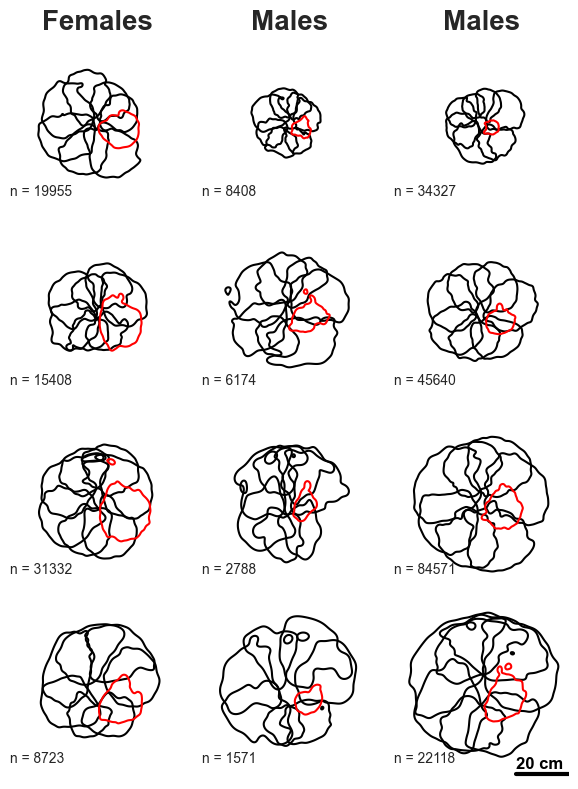

In [187]:
r = 250

GaussKernel = 0.3 ## Kernel size for the gaussian blur (fixed for between animal comparison)

color_key = {True: 'red', False:'black'}

ss = 1

scale_bar_length_cm = 20
scale_bar_length_px = scale_bar_length_cm/2.54 * 20
sx0 = 100
sx1 = sx0 + scale_bar_length_px
sy0 = r - 15
sy1 = sy0
scale_bar_text = f'{scale_bar_length_cm} cm'
stx = sx0 + (sx1-sx0)/2 - scale_bar_length_px/2
sty = sy0 - 17.5

nrows = 4
ncols = 3

fig, axs = plt.subplots(nrows, ncols, figsize=(int(2*ncols), int(2*nrows)))

pbar = tqdm(total = len(area_sorted_animals), position=0, leave=True)
for i, animal in enumerate(area_sorted_animals):
    sex = gender_key[animal]

    tmp = dat[dat['Animal ID'] == animal] ## subset big dataframe for the animal
    tmp = tmp.iloc[::ss]

    # Calculate row and column index for the subplot
    row_idx = i // ncols  # Integer division to find the row index
    col_idx = i % ncols   # Modulo operation to find the column index

    ax = axs[row_idx, col_idx]  # Assign subplot to the correct position

    if row_idx == 0:
        ax.set_title(sex + 's', rotation = 0, fontweight='bold', fontsize=20)

    if col_idx == 3 and row_idx == 0:
        legend_lines = []
        legend_labels = []
        legend_lines.append(Line2D([0], [0], color='black', lw=1))
        legend_labels.append(f'other')
        legend_lines.append(Line2D([0], [0], color='red', lw=1))
        legend_labels.append(f'R3')

        ax.legend(legend_lines, legend_labels, loc="upper right", bbox_to_anchor = (.3,1),
                   frameon=False, fontsize=10, title='90%KDE')
    n_values = None
    for xcol, ycol in list(zip(cols_x, cols_y)):
        x = np.array(tmp[xcol].tolist())
        y = np.array(tmp[ycol].tolist())
        p = np.array(tmp[xcol[:-2] + '_p'].tolist())
        idxs = np.where(p>pthresh)
        x=x[idxs]
        y=y[idxs]

        if 'r3' in xcol:
            color = color_key[True]
            g = sns.kdeplot(x=x, y=y, levels=1,
                            thresh=1-plotKthresh,
                            color=color, alpha=1,
                            ax=ax,
                            weights=GaussKernel, zorder=4)
            n_values = len(x)
        else:
            color = color_key[False]

            g = sns.kdeplot(x=x, y=y, levels=1,
                            thresh=1-plotKthresh,
                            color=color, alpha=1,
                            ax=ax,
                            weights=GaussKernel, zorder=3)

    ax.set_xlabel(f'n = {n_values}', loc='left', labelpad=-20)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.set_ylim(r, -r)
    ax.set_xlim(-r, r)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')

    if col_idx == 2 and row_idx == 3:
        ax.plot([sx0, sx1], [sy0, sy1], color='black', linewidth=3, alpha=1)
        ax.text(stx, sty, scale_bar_text, color='black', fontweight='bold',
                fontsize=12)

    pbar.update(n=1)
pbar.close()

fig.tight_layout()#w_pad=-4, h_pad=-4)

figname = 'inferencedArmTips_allAnimalsAllArms.png'
fig.savefig(os.path.join(target_dir, figname), dpi=300)

plt.show(fig)
plt.close(fig)

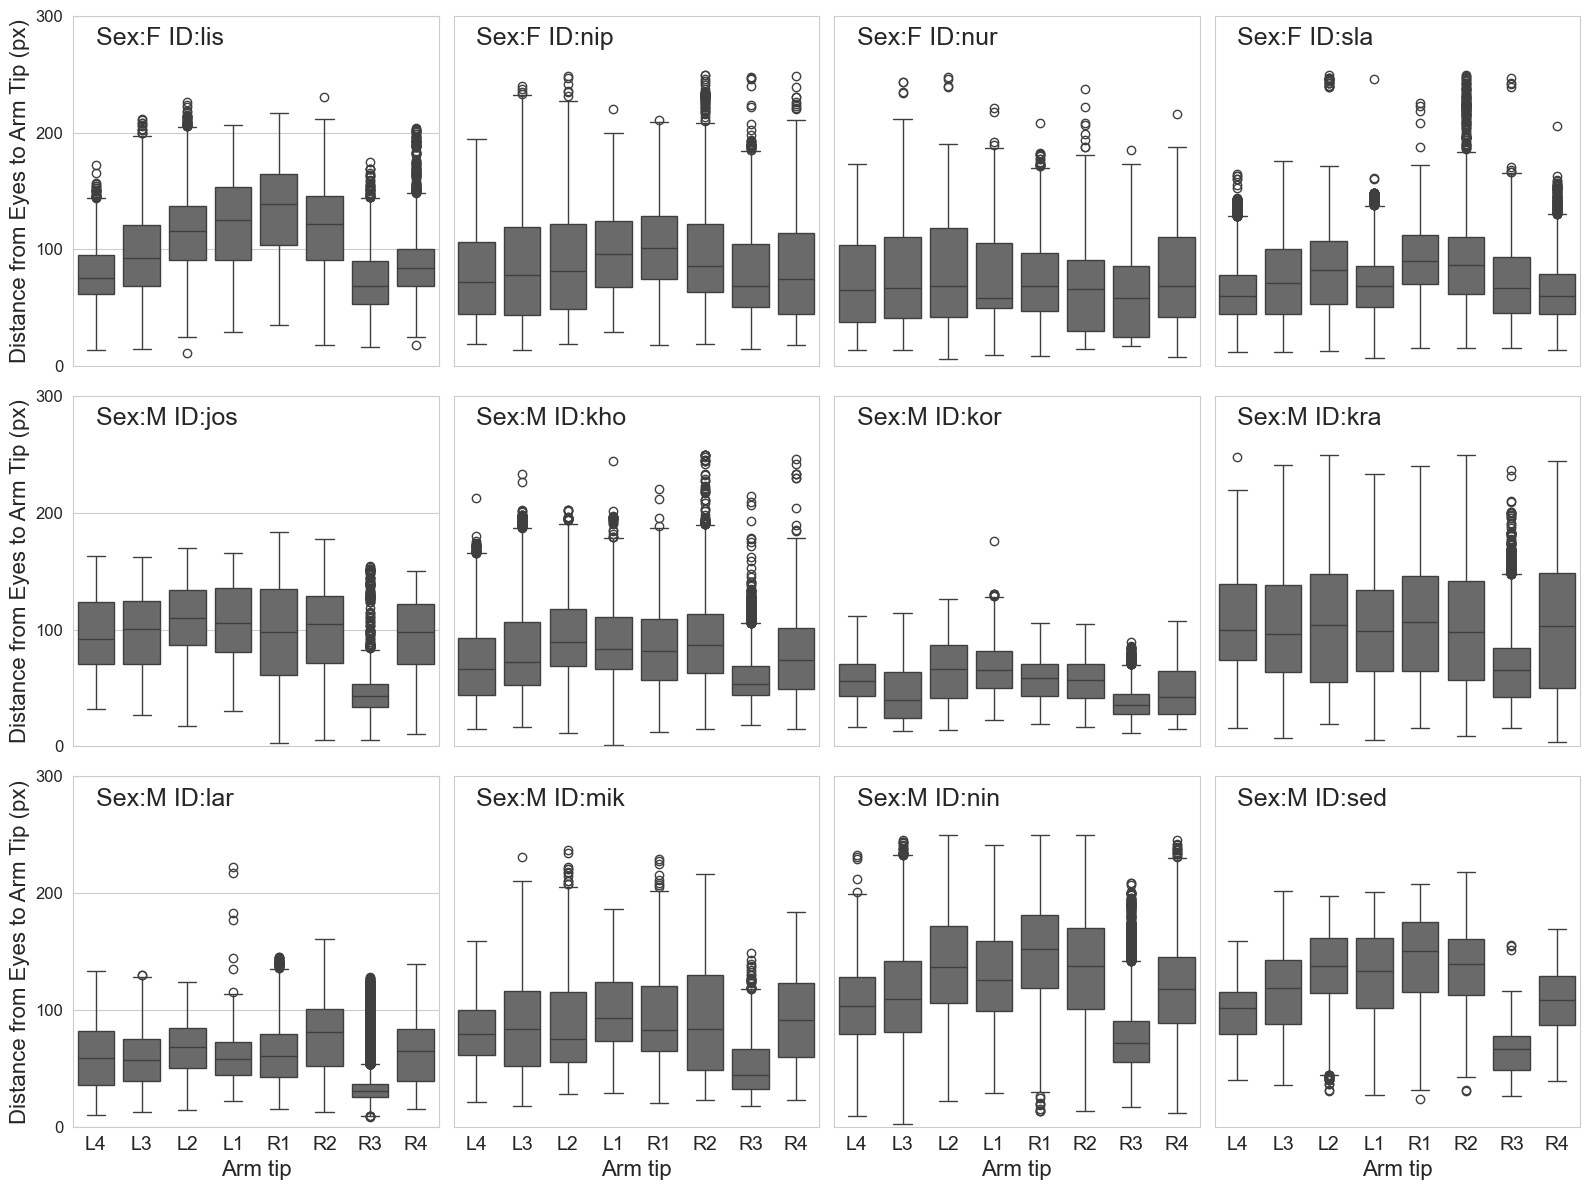

In [188]:
bodyparts = ['l4', 'l3', 'l2', 'l1', 'r1', 'r2', 'r3', 'r4']

fig, axs = plt.subplots(3,4,figsize=(16,12))

yticks = [0, 100, 200, 300]
xticks = [0,1,2,3,4,5,6,7]
xlabs = ['L4', 'L3','L2','L1',
        'R1','R2','R3','R4']

j = 0
i = 0
for animal in sorted(animals, key=sort_animals):
    tmp = DatDist[DatDist['Animal ID'] == animal].copy()
    sex = tmp['Sex'].tolist()[0]
    dct = {'Body part':[],
         'D':[]}
    for part in bodyparts:
        tmp_tmp = tmp[tmp['Body part'] == part]
        dct['D'] = dct['D'] + tmp_tmp['D'].tolist()[0].tolist()
        dct['Body part'] = dct['Body part'] + [part]*len(tmp_tmp['D'].tolist()[0].tolist())
    tmp = pd.DataFrame(dct)

    ax=axs[j ,i%4]
    g = sns.boxplot(data=tmp,
                  x='Body part', y = 'D', ax=ax, saturation=0,
                   hue_order=bodyparts)
    ax.set_ylim(0,300)
    ax.text(0,275,f'Sex:{sex} ID:{animal}', fontsize=18)

    if i in [0,4,8]:
        ax.set_ylabel('Distance from Eyes to Arm Tip (px)', fontsize=16)
        ax.set_yticks(yticks)
        ax.set_yticklabels(yticks,fontsize=12)
    else:
        ax.set_ylabel('')
        ax.set_yticks([])
    ax.set_xlabel('')

    if i >= 8:
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabs,fontsize=14)
        ax.set_xlabel('Arm tip', fontsize=16)
    else:
        ax.set_xticks([])

    i += 1
    if i%4 == 0:
        j += 1

fig.tight_layout()

fig_name = 'all_animals_distance_raw_boxplot.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300, bbox_inches='tight')

plt.show(fig)
plt.close(fig)

In [192]:
thresh = 0.1
KDE_AREAS = []

show_plots=False

for i in range(0, DatDist.shape[0]):
    Z = DatDist['KDE'][i]
    an = DatDist['Animal ID'][i]
    part = DatDist['Body part'][i]
    Zs = (Z - Z.min())/(Z.max() - Z.min())
    Z_area = np.sum(np.where(Zs > thresh, 1, 0))
    KDE_AREAS.append(Z_area)

    if show_plots == True:
        fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

        ax=ax1
        ax.imshow(Zs, extent = [-300, 300, 300, -300], zorder=0, cmap='Blues')
        ax.set_title(f'{an} {part}')
        ax.axhline(y=0, color='black', linewidth=1, zorder=1)
        ax.axvline(x=0, color='black', linewidth=1, zorder=1)
        ax.set_ylim(-300, 300)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        ax=ax2
        ax.imshow(np.where(Zs > thresh, 1, 0), extent = [-300, 300, 300, -300], zorder=0, cmap='Blues')
        ax.set_title(f'area = {Z_area}')
        ax.axhline(y=0, color='black', linewidth=1, zorder=1)
        ax.axvline(x=0, color='black', linewidth=1, zorder=1)
        ax.set_ylim(-300, 300)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        ax=ax3
        CS = ax.contour(Y, X, Zs, [thresh],
                    colors=('k',),
                    linewidths=(3,), zorder=1)
        ax.set_ylim(-300, 300)
        ax.axhline(y=0, color='black', linewidth=1, zorder=0)
        ax.axvline(x=0, color='black', linewidth=1, zorder=0)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xticks([])
        ax.set_yticks([])

        plt.show(fig)
        plt.close(fig)

DatDist[f'{int((1-thresh)*100)}%KDE Area'] = KDE_AREAS

cols = ['Animal ID', 'Sex', 'Body part', 'Distance_Mean', 'Mean X', 'Mean Y', 'x', 'y',
        'D', 'KDE', f'{int((1-thresh)*100)}%KDE Area', 'Norm_KDE_Area','Norm_distance_mean']
df = pd.DataFrame(columns=cols)

for animal in sorted(animals, key=sort_animals):
  tmp = DatDist[DatDist['Animal ID'] == animal].copy()

  A = np.array(tmp[f'{int((1-thresh)*100)}%KDE Area'].tolist())
  maxA = np.max(A)
  A = A/maxA
  tmp['Norm_KDE_Area'] = A

  D = np.array(tmp['Distance Mean'].tolist())
  maxD = np.max(D)
  norm = D/maxD
  tmp['Norm_distance_mean'] = norm

  df = pd.concat([df, tmp])

In [193]:
df['Distance_mean_cm'] = np.array(df['Distance Mean'].tolist())/20 * 2.54

## going from pixel area to cm^2
## px^2 * in^2/px^2 * cm^2/in^2 = in^2
## 1 in = 20 px
## 1 in^2 = 20^2 px^2
## 1/20^2 = in^2/px^2
## 2.54^2 cm^2 = 1 in^2
## 2.54^2/1 = cm^2/in^2
a = np.array(df['90%KDE Area'].tolist())
a = a*(1/(20**2))
a = a*((2.54**2))
df['KDE_Area_cm_2'] = a

In [194]:
[part for part in df['Body part'].unique()]

['l4', 'l3', 'l2', 'l1', 'r1', 'r2', 'r3', 'r4']

In [195]:
[sex for sex in df['Sex'].unique()]

['F', 'M']

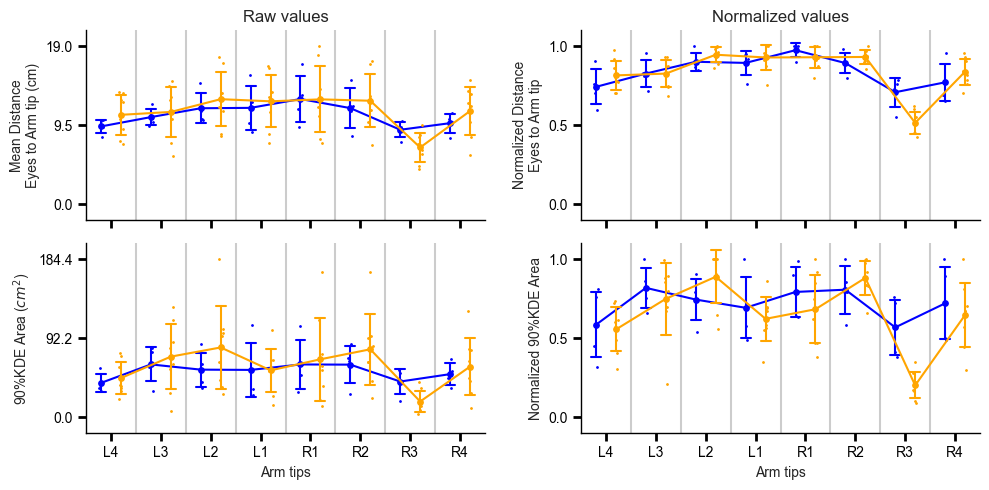

In [210]:
xticks = np.array([1,2,3,4,5,6,7,8])
xlabs = ['L4', 'L3', 'L2', 'L1', 'R1', 'R2', 'R3', 'R4']
bodyparts = [part for part in df['Body part'].unique()]
sexs = [sex for sex in df['Sex'].unique()]
yticks = [0, .5, 1]
ylims = (-.1,1.1)
dash_width = 0.1

sex_colors = {'F': 'blue', 'M':'orange'}
sex_shift = {'F':-0.2, 'M':0.2}
sex_order = {'F':1, 'M':2}

data_keys = {'Distance_mean_cm':'Mean Distance\nEyes to Arm tip (cm)',
             'Norm_distance_mean':'Normalized Distance\nEyes to Arm tip',
             'KDE_Area_cm_2':'90%KDE Area ($cm^2$)',
             'Norm_KDE_Area':'Normalized 90%KDE Area'}
keys = [s for s in data_keys.keys()]

fig, axs = plt.subplots(2,2,figsize=(10,5))

n = 0
for i in range(0,2):
    for j in range(0,2):
        ax=axs[i,j]
        key = keys[n]

        max_value = 0
        for k, sex in enumerate(sexs):
            for l, part in enumerate(bodyparts):
                tmp = df[(df['Body part'] == part) & (df['Sex'] == sex)]
                value = tmp[key]
                mxv = np.max(value)
                if mxv > max_value:
                    max_value = mxv

        for k, sex in enumerate(sexs):
            color = sex_colors[sex]
            mean_values = []
            std_values = []

            for l, part in enumerate(bodyparts):
                tmp = df[(df['Body part'] == part) & (df['Sex'] == sex)]

                value = tmp[key]/max_value

                mean_value = np.mean(value)
                mean_values.append(mean_value)

                std_value = np.std(value)

                xp = xticks[l]+sex_shift[sex]+np.random.uniform(-.05, .05, len(value))
                ax.scatter(xp, value, color=color, zorder=sex_order[sex], s=1)

                ax.scatter(xticks[l]+sex_shift[sex], mean_value, color=color,
                           zorder=sex_order[sex], s=15)
                ax.plot([xticks[l]+sex_shift[sex],xticks[l]+sex_shift[sex]],
                        [mean_value-std_value,mean_value+std_value],
                        color=color, zorder=sex_order[sex])
                ax.plot([xticks[l]+sex_shift[sex]-dash_width,xticks[l]+sex_shift[sex]+dash_width],
                        [mean_value-std_value,mean_value-std_value],
                        color=color, zorder=sex_order[sex]
                        )
                ax.plot([xticks[l]+sex_shift[sex]-dash_width,xticks[l]+sex_shift[sex]+dash_width],
                        [mean_value+std_value,mean_value+std_value],
                        color=color, zorder=sex_order[sex]
                        )


            ax.plot(xticks+sex_shift[sex], mean_values, color=color,
                    zorder=sex_order[sex])

        ax.set_ylabel(data_keys[key])

        ax.set_xticks(xticks)
        if i == 1:
            ax.set_xticklabels(xlabs)
            ax.set_xlabel('Arm tips')
        else:
            ax.set_xticklabels(['' for x in xticks])

        if i == 0 and j == 0:
            ax.set_title('Raw values')
        elif i == 0 and j == 1:
            ax.set_title('Normalized values')

        ax.set_ylim(ylims)
        ax.set_xlim((xticks[0]-.5, xticks[-1]+.5))

        ax.set_yticks(yticks)
        ax.set_yticklabels([str(round(tick*max_value,1)) for tick in yticks])

        for tick in xticks[:-1]:
            ax.axvline(x=tick+0.5, color='black', zorder=0, alpha=0.2)

        ax.grid(None)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # Customizing spine colors and thickness
        for spine in ax.spines.values():
            spine.set_color('black')  # Set the color of the spine
            spine.set_linewidth(1)  # Set the thickness of the spine
        # Customize ticks on the x-axis and y-axis
        ax.tick_params(axis='x', which='both',
                       direction='out', length=6, width=2,
                       colors='black',
                   grid_color='black', grid_alpha=0.5,
                       labelsize='medium',bottom=True, top=False)
        ax.tick_params(axis='y', which='both',
                       direction='out', length=6, width=2,
                       colors='black', left=True, right=False)

        n += 1

fig.tight_layout(w_pad=2)

figname = 'distribution_of_inferenced_values.png'
fig.savefig(os.path.join(target_dir, figname), dpi=300)

plt.show(fig)
plt.close(fig)

In [197]:
df['Arm_tip'] = df['Body part'].astype('category') ## make the aov model outs easier to understand

In [198]:
model = ols(r'Distance_mean_cm ~ C(Sex) + C(Arm_tip) + C(Sex):C(Arm_tip)',
            data=df).fit()
round(sm.stats.anova_lm(model, typ=2),4)

sum_sq    df       F  PR(>F)
C(Sex)               5.4785   1.0  0.6432  0.4249
C(Arm_tip)         231.5087   7.0  3.8827  0.0011
C(Sex):C(Arm_tip)   25.2962   7.0  0.4243  0.8844
Residual           681.4338  80.0     NaN     NaN

In [199]:
model = ols(r'Norm_distance_mean ~ C(Sex) + C(Arm_tip) + C(Sex):C(Arm_tip)',
            data=df).fit()
round(sm.stats.anova_lm(model, typ=2),5)

sum_sq    df         F   PR(>F)
C(Sex)             0.00012   1.0   0.01668  0.89755
C(Arm_tip)         1.22927   7.0  25.01702  0.00000
C(Sex):C(Arm_tip)  0.14394   7.0   2.92929  0.00881
Residual           0.56157  80.0       NaN      NaN

In [200]:
model = ols(r'KDE_Area_cm_2 ~ C(Sex) + C(Arm_tip) + C(Sex):C(Arm_tip)',
            data=df).fit()
round(sm.stats.anova_lm(model, typ=2),5)

sum_sq    df        F   PR(>F)
C(Sex)               817.07943   1.0  0.69174  0.40805
C(Arm_tip)         21965.88343   7.0  2.65662  0.01598
C(Sex):C(Arm_tip)   3876.27107   7.0  0.46881  0.85437
Residual           94495.44502  80.0      NaN      NaN

In [201]:
model = ols(r'Norm_KDE_Area ~ C(Sex) + C(Arm_tip) + C(Sex):C(Arm_tip)',
            data=df).fit()
round(sm.stats.anova_lm(model, typ=2),5)

sum_sq    df         F   PR(>F)
C(Sex)             0.08333   1.0   2.41966  0.12377
C(Arm_tip)         2.49295   7.0  10.34113  0.00000
C(Sex):C(Arm_tip)  0.41947   7.0   1.74002  0.11143
Residual           2.75510  80.0       NaN      NaN

Comparing Normalized Means of Arm-tip Distance from the Eyes
	Female, Front to Back: t(15,11) = T(3.7973); p = 0.00079
	Female, R3 to Front: t(3,11) = T(-4.66475); p = 0.00019
	Female, R3 to Back: t(3,15) = T(-1.09136); p = 0.294
	Male, Front to Back: t(31,23) = T(5.31214); p = 2e-06
	Male, R3 to Front: t(7,23) = T(-16.56808); p = 6e-19
	Male, R3 to Back: t(7,31) = T(-8.94906); p = 6e-10

Comparing Normalized Arm-tip 90%KDE Areas
	Female, Front to Back: t(15,11) = T(0.68372); p = 0.5002
	Female, R3 to Front: t(3,11) = T(-1.9342); p = 0.06897
	Female, R3 to Back: t(3,15) = T(-1.10557); p = 0.288
	Male, Front to Back: t(31,23) = T(2.11094); p = 0.039
	Male, R3 to Front: t(7,23) = T(-7.62639); p = 4e-09
	Male, R3 to Back: t(7,31) = T(-5.75482); p = 3e-06


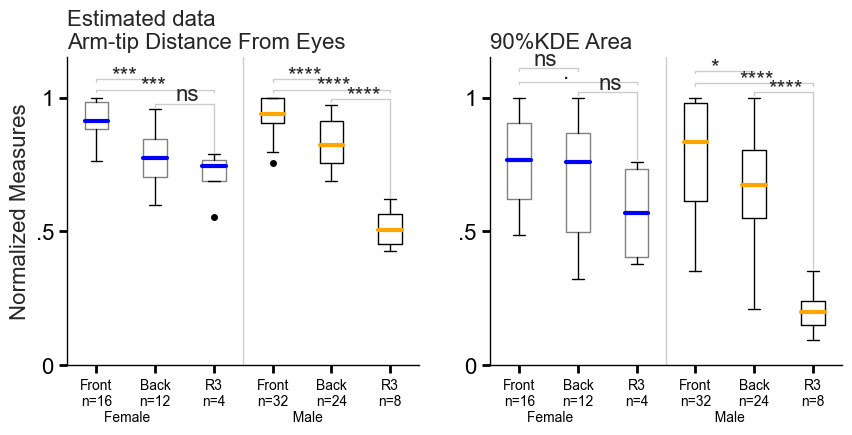

In [202]:
def get_p_symbol(p, alpha=0.05):
    if p > alpha+0.05:
        return 'ns'
    elif p > alpha:
        return '.'
    elif p > 0.01:
        return '*'
    elif p > 0.001:
        return '**'
    elif p > 0.0001:
        return '***'
    else:
        return '****'

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

dat_r3 = df[df['Arm_tip'] == 'r3']
dat_front = df[(df['Arm_tip'] == 'l2') | (df['Arm_tip'] == 'l1') | (df['Arm_tip'] == 'r1') | (df['Arm_tip'] == 'r2')]
dat_back = df[(df['Arm_tip'] == 'l4') | (df['Arm_tip'] == 'l3') | (df['Arm_tip'] == 'r4')]

print('Comparing Normalized Means of Arm-tip Distance from the Eyes')

## Dist ##
# Female #
r3_f = np.array(dat_r3[dat_r3['Sex'] == 'F']['Norm_distance_mean'].tolist())
r3_front_f = np.array(dat_front[dat_front['Sex'] == 'F']['Norm_distance_mean'].tolist())
r3_back_f = np.array(dat_back[dat_back['Sex'] == 'F']['Norm_distance_mean'].tolist())
f_r3_to_back = stats.ttest_ind(r3_f, r3_back_f)
f_r3_to_front = stats.ttest_ind(r3_f, r3_front_f)
f_front_to_back = stats.ttest_ind(r3_front_f, r3_back_f)

print(f'\tFemale, Front to Back: t({len(r3_front_f)-1},{len(r3_back_f)-1}) = T({round(f_front_to_back.statistic,5)}); p = {round(f_front_to_back.pvalue,5)}')
print(f'\tFemale, R3 to Front: t({len(r3_f)-1},{len(r3_back_f)-1}) = T({round(f_r3_to_front.statistic,5)}); p = {round(f_r3_to_front.pvalue,5)}')
print(f'\tFemale, R3 to Back: t({len(r3_f)-1},{len(r3_front_f)-1}) = T({round(f_r3_to_back .statistic,5)}); p = {round(f_r3_to_back .pvalue,3)}')

# Male #
r3_m = np.array(dat_r3[dat_r3['Sex'] == 'M']['Norm_distance_mean'].tolist())
r3_front_m = np.array(dat_front[dat_front['Sex'] == 'M']['Norm_distance_mean'].tolist())
r3_back_m = np.array(dat_back[dat_back['Sex'] == 'M']['Norm_distance_mean'].tolist())
m_r3_to_back = stats.ttest_ind(r3_m, r3_back_m)
m_r3_to_front = stats.ttest_ind(r3_m, r3_front_m)
m_front_to_back = stats.ttest_ind(r3_front_m, r3_back_m)

print(f'\tMale, Front to Back: t({len(r3_front_m)-1},{len(r3_back_m)-1}) = T({round(m_front_to_back.statistic,5)}); p = {round(m_front_to_back.pvalue,6)}')
print(f'\tMale, R3 to Front: t({len(r3_m)-1},{len(r3_back_m)-1}) = T({round(m_r3_to_front.statistic,5)}); p = {round(m_r3_to_front.pvalue,19)}')
print(f'\tMale, R3 to Back: t({len(r3_m)-1},{len(r3_front_m)-1}) = T({round(m_r3_to_back .statistic,5)}); p = {round(m_r3_to_back .pvalue,10)}')

print()
print('Comparing Normalized Arm-tip 90%KDE Areas')

# plotting #
ax=ax1
# params #
pos = [0, 1, 2, 3, 4, 5]
wds = [.4]*6
xticks = pos
xlabs = ['Front\nn=32\n                  Male', 'Back\nn=24', 'R3\nn=8', 'Front\nn=16\n                Female', 'Back\nn=12', 'R3\nn=4']
xlabs = xlabs[3:] + xlabs[:3]
yticks = [0, 0.5, 1]
ylabs = ['0', '.5', '1']
ax.tick_params(bottom=True, left=True)
# male #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color='black')
ax.boxplot([r3_front_m, r3_back_m, r3_m], positions = pos[3:], widths = wds[3:],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
# Female #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color='grey')
ax.boxplot([r3_front_f, r3_back_f, r3_f], positions = pos[:3], widths = wds[:3],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
# plot settings #
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs,fontsize=16)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabs,fontsize=16)
ax.axvline(x=(pos[3]+pos[2])/2, color='black', linewidth=1, alpha=0.2)
ax.set_ylabel('Normalized Measures',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Estimated data\nArm-tip Distance From Eyes', loc='left', fontsize=16)
ax.set_ylim(0, 1.15)

# draw comparison lines #
# Male #
# front to back #
b = 3
h = .01
sh = .05
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 4
h = .01
sh = 0
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_m)+h+sh, max(r3_back_m)+h+h+sh, max(r3_back_m)+h+h+sh, max(r3_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 3
h = .01
sh = 0.01
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

# Female #
# front to back #
b = 0
h = .01
sh = .05
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 1
h = .01
sh = 0
th = .01
tb = -.15
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_f)+h+sh, max(r3_back_f)+h+h+sh, max(r3_back_f)+h+h+sh, max(r3_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 0
h = .01
sh = 0.01
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

## KDE ##
# Female #
r3_f = np.array(dat_r3[dat_r3['Sex'] == 'F']['Norm_KDE_Area'].tolist())
r3_front_f = np.array(dat_front[dat_front['Sex'] == 'F']['Norm_KDE_Area'].tolist())
r3_back_f = np.array(dat_back[dat_back['Sex'] == 'F']['Norm_KDE_Area'].tolist())
f_r3_to_back = stats.ttest_ind(r3_f, r3_back_f)
f_r3_to_front = stats.ttest_ind(r3_f, r3_front_f)
f_front_to_back = stats.ttest_ind(r3_front_f, r3_back_f)

print(f'\tFemale, Front to Back: t({len(r3_front_f)-1},{len(r3_back_f)-1}) = T({round(f_front_to_back.statistic,5)}); p = {round(f_front_to_back.pvalue,5)}')
print(f'\tFemale, R3 to Front: t({len(r3_f)-1},{len(r3_back_f)-1}) = T({round(f_r3_to_front.statistic,5)}); p = {round(f_r3_to_front.pvalue,5)}')
print(f'\tFemale, R3 to Back: t({len(r3_f)-1},{len(r3_front_f)-1}) = T({round(f_r3_to_back .statistic,5)}); p = {round(f_r3_to_back .pvalue,3)}')

# Male #
r3_m = np.array(dat_r3[dat_r3['Sex'] == 'M']['Norm_KDE_Area'].tolist())
r3_front_m = np.array(dat_front[dat_front['Sex'] == 'M']['Norm_KDE_Area'].tolist())
r3_back_m = np.array(dat_back[dat_back['Sex'] == 'M']['Norm_KDE_Area'].tolist())
m_r3_to_back = stats.ttest_ind(r3_m, r3_back_m)
m_r3_to_front = stats.ttest_ind(r3_m, r3_front_m)
m_front_to_back = stats.ttest_ind(r3_front_m, r3_back_m)

print(f'\tMale, Front to Back: t({len(r3_front_m)-1},{len(r3_back_m)-1}) = T({round(m_front_to_back.statistic,5)}); p = {round(m_front_to_back.pvalue,3)}')
print(f'\tMale, R3 to Front: t({len(r3_m)-1},{len(r3_back_m)-1}) = T({round(m_r3_to_front.statistic,5)}); p = {round(m_r3_to_front.pvalue,9)}')
print(f'\tMale, R3 to Back: t({len(r3_m)-1},{len(r3_front_m)-1}) = T({round(m_r3_to_back .statistic,5)}); p = {round(m_r3_to_back .pvalue,6)}')

# plotting #
ax=ax2
# params #
pos = [0, 1, 2, 3, 4, 5]
wds = [.4]*6
xticks = pos
xlabs = ['Front\nn=32\n                  Male', 'Back\nn=24', 'R3\nn=8', 'Front\nn=16\n                Female', 'Back\nn=12', 'R3\nn=4']
xlabs = xlabs[3:] + xlabs[:3]
yticks = [0, 0.5, 1]
ylabs = ['0', '.5', '1']
ax.tick_params(bottom=True, left=True)
# male #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color='black')
ax.boxplot([r3_front_m, r3_back_m, r3_m], positions = pos[3:], widths = wds[3:],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
# Female #
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')
medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color='grey')
ax.boxplot([r3_front_f, r3_back_f, r3_f], positions = pos[:3], widths = wds[:3],
          flierprops=flierprops, medianprops=medianprops, boxprops=boxprops)
# plot settings #
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs,fontsize=16)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabs,fontsize=16)
ax.axvline(x=(pos[3]+pos[2])/2, color='black', linewidth=1, alpha=0.2)
#ax.set_ylabel('Normalized Measures',fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('90%KDE Area', loc='left', fontsize=16)
ax.set_ylim(0, 1.15)

# draw comparison lines #
# Male #
# front to back #
b = 3
h = .01
sh = .08
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 4
h = .01
sh = 0.0
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_m)+h+sh, max(r3_back_m)+h+h+sh, max(r3_back_m)+h+h+sh, max(r3_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 3
h = .01
sh = 0.035
th = -.01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_m)+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+h+sh, max(r3_front_m)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = m_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

# Female #
# front to back #
b = 0
h = .01
sh = .09
th = .01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_front_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# back to r3 #
b = 1
h = .01
sh = 0
th = .01
tb = -.15
xpos = [pos[b], pos[b], pos[b+1], pos[b+1]]
ypos = [max(r3_back_f)+h+sh, max(r3_back_f)+h+h+sh, max(r3_back_f)+h+h+sh, max(r3_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_back.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)
# front to r3 #
b = 0
h = .01
sh = 0.04
th = .01
tb = -.25
xpos = [pos[b], pos[b], pos[b+1+1], pos[b+1+1]]
ypos = [max(r3_front_f)+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+h+sh, max(r3_front_f)+h+sh]
ax.plot(xpos, ypos, color='black', linewidth=1, alpha=0.2)
p = f_r3_to_front.pvalue
ax.text((xpos[2]+xpos[1])/2+tb, ypos[1]+th, get_p_symbol(p), fontsize=16)

ax = ax1
ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both',
               direction='out', length=6, width=2,
               colors='black',
           grid_color='black', grid_alpha=0.5,
               labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both',
               direction='out', length=6, width=2,
               colors='black', left=True, right=False)

ax=ax2
ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both',
               direction='out', length=6, width=2,
               colors='black',
           grid_color='black', grid_alpha=0.5,
               labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both',
               direction='out', length=6, width=2,
               colors='black', left=True, right=False)

fig_name = 'full_male-to-female-comparison.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

Ttest_indResult(statistic=3.7822548485506315, pvalue=0.003588663221958824)
Ttest_indResult(statistic=4.53658361982179, pvalue=0.0010803751304558145)


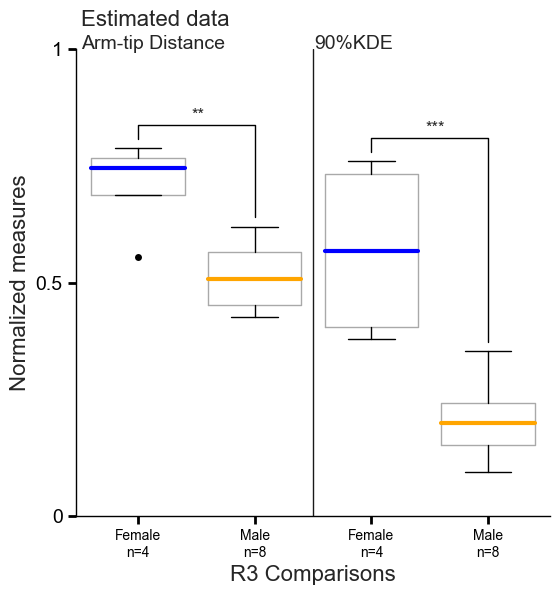

In [203]:
fig, (ax1) = plt.subplots(1,1,figsize=(6,6))

col_kde = 'darkgrey'
col_dst = 'dimgrey'
flierprops = dict(marker='.', markerfacecolor='black', markersize=10,
                  markeredgecolor='none')

txtpad = .01
pvpad = .02
pvlim = .05
wds = .2
pos = [0.25, .5, .75, 1]
ax=ax1
F_ND = np.array(df[(df['Sex'] == 'F') & (df['Arm_tip'] == 'r3')]['Norm_distance_mean'].tolist()).astype('float')
M_ND = np.array(df[(df['Sex'] == 'M') & (df['Arm_tip'] == 'r3')]['Norm_distance_mean'].tolist()).astype('float')
ND_out = stats.ttest_ind(F_ND, M_ND)
print(ND_out)

medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color=col_kde)
ax.boxplot([F_ND],
           positions=[pos[0]],
           widths=[wds],
           flierprops=flierprops,
           medianprops=medianprops,
           boxprops=boxprops)
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color=col_kde)
ax.boxplot([M_ND],
           positions=[pos[1]],
           widths=[wds],
           flierprops=flierprops,
           medianprops=medianprops,
           boxprops=boxprops)


px = [pos[0], pos[0], pos[1], pos[1]]
py = [max(F_ND)+pvpad, max(F_ND)+pvlim, max(F_ND)+pvlim, max(M_ND)+pvpad]
ax.plot(px, py, color='black', linewidth=1)
p = round(ND_out.pvalue,3)
ax.text((px[0]+px[2])/2-txtpad,py[1]+txtpad, f'{get_p_symbol(p)}',fontsize=12)

F_NA = np.array(df[(df['Sex'] == 'F') & (df['Arm_tip'] == 'r3')]['Norm_KDE_Area'].tolist()).astype('float')
M_NA = np.array(df[(df['Sex'] == 'M') & (df['Arm_tip'] == 'r3')]['Norm_KDE_Area'].tolist()).astype('float')
NA_out = stats.ttest_ind(F_NA, M_NA)
print(NA_out)

medianprops = dict(linestyle='-', linewidth=3, color='blue')
boxprops = dict(linestyle='-', linewidth=1, color=col_kde)
ax.boxplot([F_NA],
           positions=[pos[2]],
           widths=[wds],
           flierprops=flierprops,
           medianprops=medianprops,
           boxprops=boxprops)
medianprops = dict(linestyle='-', linewidth=3, color='orange')
boxprops = dict(linestyle='-', linewidth=1, color=col_kde)
ax.boxplot([M_NA],
           positions=[pos[3]],
           widths=[wds],
           flierprops=flierprops,
           medianprops=medianprops,
           boxprops=boxprops)

px = [pos[2], pos[2], pos[3], pos[3]]
py = [max(F_NA)+pvpad, max(F_NA)+pvlim, max(F_NA)+pvlim, max(M_NA)+pvpad]
ax.plot(px, py, color='black', linewidth=1)
p = round(NA_out.pvalue,3)
ax.text((px[0]+px[2])/2-txtpad,py[1]+txtpad, f'{get_p_symbol(p)}',fontsize=12)

xticks = pos
xlabs = [f'Female\nn={len(F_ND)}',f'Male\nn={len(M_ND)}',f'Female\nn={len(F_NA)}',f'Male\nn={len(M_NA)}']
ax.set_xticks(xticks)
ax.set_xticklabels(xlabs,
                   rotation=0,
                  fontsize=14)
ax.set_xlim(pos[0]-wds/1.5, pos[-1]+wds/1.5)
ax.set_yticks([0, .5, 1])
ax.set_yticklabels([0,.5,1], fontsize=14)
ax.set_ylabel('Normalized measures',fontsize=16)
ax.set_aspect(1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('R3 Comparisons',fontsize=16)

ax.axvline(x = (pos[2]+pos[1])/2, linewidth=1, color='black', alpha=0.9)
ax.text(pos[0]-wds/2-.023, 1.05, 'Estimated data', fontsize=16)
ax.text(pos[0]-wds/2-.023, 1., 'Arm-tip Distance', fontsize=14)
ax.text(pos[2]-wds/2-.023, 1., '90%KDE', fontsize=14)

ax = ax1
ax.grid(None)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Customizing spine colors and thickness
for spine in ax.spines.values():
    spine.set_color('black')  # Set the color of the spine
    spine.set_linewidth(1)  # Set the thickness of the spine

# Customize ticks on the x-axis and y-axis
ax.tick_params(axis='x', which='both',
               direction='out', length=6, width=2,
               colors='black',
           grid_color='black', grid_alpha=0.5,
               labelsize='medium',bottom=True, top=False)
ax.tick_params(axis='y', which='both',
               direction='out', length=6, width=2,
               colors='black', left=True, right=False)

fig.tight_layout()

fig_name = 'male-to-female-comparison.png'
path_fig = os.path.join(target_dir, fig_name)
fig.savefig(path_fig, dpi=300)

plt.show(fig)
plt.close(fig)

In [204]:
df_inf = df.copy()

In [205]:
df_annos

folders animal sex        imgs  lefteye_x  lefteye_y  \
0               10069_10089_fc    nur   F   img08.png  -7.495331   2.444130   
1               10069_10089_fc    nur   F   img12.png  -7.542636   2.451357   
2               10069_10089_fc    nur   F   img14.png  -7.034691   1.918552   
3               10141_10265_fc    sla   F  img035.png   2.843202   6.225631   
4               10141_10265_fc    sla   F  img037.png   2.818633   6.149745   
...                        ...    ...  ..         ...        ...        ...   
2333  slaanesh_9_3_tracking_01    sla   F  img303.png  -4.757353   5.352022   
2334  slaanesh_9_3_tracking_01    sla   F  img305.png  -4.333354   5.245640   
2335  slaanesh_9_3_tracking_01    sla   F  img320.png  -4.999200   4.781844   
2336  slaanesh_9_3_tracking_01    sla   F  img326.png  -4.613469   4.823172   
2337  slaanesh_9_3_tracking_01    sla   F  img368.png  -4.687707   5.437740   

      righteye_x  righteye_y  mantle_tip_x  mantle_tip_y  ...  \
0       7.495331   -2.444130    -12.383590     50.349069  ...   
1       7.542636   -2.451357      2.262791     48.461438  ...   
2       7.034691   -1.918552      3.908162     47.395343  ...   
3      -2.843202   -6.225631     37.255747    -11.715952  ...   
4      -2.818633   -6.149745     39.204626    -11.787012  ...   
...          ...         ...           ...           ...  ...   
2333    4.757353   -5.352022     29.337008     28.345893  ...   
2334    4.333354   -5.245640     31.701909     27.596626  ...   
2335    4.999200   -4.781844     31.516696     25.213357  ...   
2336    4.613469   -4.823172     37.746563     20.341203  ...   
2337    4.687707   -5.437740     34.689030     21.563451  ...   

      Distance_between_eyes_cm  Distance_eyes_to_mantle_tip_cm  l4_tip_D_cm  \
0                     2.002476                        6.584900    13.248401   
1                     2.014470                        6.161308    16.234120   
2                     1.852071                        6.039637    16.774655   
3                     1.738412                        4.959922    11.161536   
4                     1.718288                        5.199152    10.227482   
...                        ...                             ...          ...   
2333                  1.818834                        5.180837     7.374702   
2334                  1.728221                        5.337906     3.365186   
2335                  1.757159                        5.125855     9.919773   
2336                  1.695287                        5.445572     7.949328   
2337                  1.823565                        5.187311    13.972082   

      l3_tip_D_cm  l2_tip_D_cm  l1_tip_D_cm  r1_tip_D_cm  r2_tip_D_cm  \
0       10.689237    11.924721     9.995880     7.910842    11.902076   
1       17.152232    15.098229    12.346074    12.876627    12.515925   
2       19.328611    17.213160    12.125609    12.129613    11.926637   
3       11.827023     9.296038    10.778749    11.276366    14.145746   
4       12.077397    10.487796     8.850696     6.954792     9.366900   
...           ...          ...          ...          ...          ...   
2333    12.622382    10.719677    12.765648    11.932975    10.345422   
2334    13.122480    14.512908    10.903256    13.550507     6.896481   
2335    11.508866     9.544416    12.688633    10.036766     5.806421   
2336    13.624106    14.832659     7.461655    10.134175     9.407536   
2337          NaN    15.998205     4.444530     5.129706     8.406487   

      r3_tip_D_cm  r4_tip_D_cm  
0       11.496294     7.658013  
1       10.027598    11.258949  
2       10.743077     9.317529  
3       10.372180    10.955574  
4       10.056919     9.560380  
...           ...          ...  
2333     9.621764     6.148774  
2334     7.785621    10.886006  
2335    11.042574     6.768680  
2336          NaN    10.266431  
2337    11.375053     8.602264  

[2338 rows x 36 columns]

In [206]:
dat_annos

Animal Sex Arm_tip  Distance_to_Arm_Tip_CM
0        nur   F  l4_tip               13.248401
1        nur   F  l3_tip               10.689237
2        nur   F  l2_tip               11.924721
3        nur   F  l1_tip                9.995880
4        nur   F  r1_tip                7.910842
...      ...  ..     ...                     ...
18699    sla   F  l1_tip                4.444530
18700    sla   F  r1_tip                5.129706
18701    sla   F  r2_tip                8.406487
18702    sla   F  r3_tip               11.375053
18703    sla   F  r4_tip                8.602264

[17804 rows x 4 columns]

In [207]:
dat_inf

lefteye_x     lefteye_y  lefteye_p  righteye_x    righteye_y  \
0       -7.091514 -2.708944e-14   0.999639    7.091514 -4.440892e-16   
1       -6.877216  1.065814e-13   0.999642    6.877216  0.000000e+00   
2       -4.912697 -2.353673e-14   0.998512    4.912697  4.440892e-16   
3       -3.520065  1.665335e-16   0.987928    3.520065 -1.665335e-16   
4       -7.201869  1.859624e-15   0.551609    7.201869 -4.135581e-15   
...           ...           ...        ...         ...           ...   
440170  -6.580385 -8.215650e-14   1.000000    6.580385  2.220446e-16   
440171  -6.576897 -4.773959e-14   1.000000    6.576897  6.661338e-16   
440172  -6.114338 -1.110223e-15   1.000000    6.114338  1.110223e-15   
440173  -5.970222 -1.911804e-13   1.000000    5.970222  6.661338e-16   
440174  -6.304863 -6.661338e-16   1.000000    6.304863  6.661338e-16   

        righteye_p  mantle_tip_x  mantle_tip_y  mantle_tip_p   l1_tip_x  ...  \
0         0.998700     -1.629828     67.371721      0.999813  -7.442511  ...   
1         0.994357     -8.067468     66.878371      0.999930   1.498255  ...   
2         0.986206    -32.156033     61.497225      0.999568  -2.608494  ...   
3         0.842734    -68.206158      1.065913      0.996190  65.397498  ...   
4         0.949737    -47.844629      3.149648      0.068275  33.062704  ...   
...            ...           ...           ...           ...        ...  ...   
440170    1.000000     -2.434960     36.306346      1.000000 -30.031311  ...   
440171    1.000000      0.261601     37.949745      1.000000 -33.862144  ...   
440172    1.000000      0.250270     38.643584      0.999998 -30.480837  ...   
440173    1.000000     -2.850060     35.024094      1.000000 -27.377723  ...   
440174    1.000000     -1.874285     34.218783      1.000000 -33.063160  ...   

          l2_tip_x    l2_tip_y  l2_tip_p  Animal ID                     Root  \
0       -10.919028  126.643049  0.990198        jos           joseph-14_50-9   
1       -22.144200  116.118250  0.990198        jos           joseph-14_50-9   
2       -50.194526   96.467108  0.990198        jos           joseph-14_50-9   
3       -96.058205    4.944616  0.990198        jos           joseph-14_50-9   
4      -145.474333   14.370104  0.854501        jos           joseph-14_50-9   
...            ...         ...       ...        ...                      ...   
440170 -107.189051  -40.752430  1.000000        sla  slaanesh_9_9_100_eat_01   
440171 -125.434971  -43.551070  0.999983        sla  slaanesh_9_9_100_eat_01   
440172 -120.015131  -49.190872  0.999515        sla  slaanesh_9_9_100_eat_01   
440173 -120.826247  -52.079239  0.999949        sla  slaanesh_9_9_100_eat_01   
440174 -127.598414  -43.672204  0.999779        sla  slaanesh_9_9_100_eat_01   

        Index    Meaneye_x   Meaneye_y  Body_Axis_angle  InCircle  
0           0   618.134811  221.389709         1.824976      True  
1           1   620.051010  230.094574         1.923755      True  
2           2   624.181534  239.036423         2.191086      True  
3           3   628.906067  251.099319        -3.083586      True  
4           4   630.159149  234.567696        -3.121612      True  
...       ...          ...         ...              ...       ...  
440170   2551  1153.118546  227.175125         1.848066      True  
440171   2552  1150.208679  223.345291         1.780042      True  
440172   2553  1146.909042  221.107773         1.842763      True  
440173   2554  1144.773621  220.900040         1.864234      True  
440174   2555  1142.662415  220.862518         1.795716      True  

[408985 rows x 40 columns]

In [208]:
df_inf

Animal ID Sex Body part Distance_Mean      Mean X      Mean Y  \
0        lis   F        l4           NaN  -24.909656   67.130702   
1        lis   F        l3           NaN  -76.766859   27.690496   
2        lis   F        l2           NaN  -83.816528  -58.992704   
3        lis   F        l1           NaN  -25.086621 -110.899041   
4        lis   F        r1           NaN   55.515226 -111.881943   
..       ...  ..       ...           ...         ...         ...   
91       sed   M        l1           NaN  -51.733735 -113.456204   
92       sed   M        r1           NaN   52.870972 -120.011168   
93       sed   M        r2           NaN  107.364360  -55.765365   
94       sed   M        r3           NaN   54.886248   24.080718   
95       sed   M        r4           NaN   51.409548   86.162499   

                                                    x  \
0   [-17.72778940298718, -18.02680894262745, -31.0...   
1   [-45.629707526039134, -35.052670841196196, -40...   
2   [-50.9676538396767, -50.980793516735105, -51.4...   
3   [-54.30897801923834, -45.822400569849215, -25....   
4   [27.04491947946829, 11.28418650458644, 20.9911...   
..                                                ...   
91  [-83.61176108685473, -76.01059048385578, -61.1...   
92  [134.8188641488534, 134.61054511991023, 128.25...   
93  [141.76424372071062, 94.33213270937334, 86.481...   
94  [54.08180771671144, 54.512340601930845, 53.264...   
95  [40.99929681804314, 43.58151336544584, 40.5153...   

                                                    y  \
0   [77.14324823107094, 72.39392678245227, 62.6025...   
1   [25.602089438177323, 32.14178980445008, 35.662...   
2   [-25.218791613550977, -16.702998635385125, -9....   
3   [-92.40058871933398, -82.24409230256646, -39.6...   
4   [-51.58628720156246, -59.83183336124446, -45.1...   
..                                                ...   
91  [-158.66191298783056, -160.8681398482753, -163...   
92  [-40.24199763940478, -30.88216506847302, -26.9...   
93  [-72.23316604514254, -23.094189946700943, -20....   
94  [36.04690819158908, 35.75301184308548, 39.2471...   
95  [88.15990030757027, 87.66160425085877, 89.1848...   

                                                    D  \
0   [79.15399714958996, 74.60460090126516, 69.8905...   
1   [52.32147926532949, 47.558221002626844, 54.300...   
2   [56.865536033425556, 53.64728763888867, 52.264...   
3   [107.17898063134218, 94.14766652794316, 47.251...   
4   [58.24579552974627, 60.886625365822475, 49.774...   
..                                                ...   
91  [179.34472176510573, 177.9218038463771, 174.92...   
92  [140.6966399897199, 138.10759203170477, 131.06...   
93  [159.1060372035272, 97.11793279715712, 88.7918...   
94  [64.99401138628235, 65.19105102506578, 66.1622...   
95  [97.2271071348661, 97.8974216568379, 97.956277...   

                                                  KDE 90%KDE Area  \
0   [[1.0396288341757843e-237, 6.959006370301371e-...        2143   
1   [[9.732510196935346e-101, 1.3535904871662602e-...        5041   
2   [[9.924314384153817e-86, 1.4123390292179589e-8...        5275   
3   [[6.708104182883746e-75, 6.298439238681346e-74...        6663   
4   [[1.0276525405148904e-267, 7.407043492900643e-...        6600   
..                                                ...         ...   
91  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        4139   
92  [[1.6819961862256246e-169, 6.95677109270966e-1...        7069   
93  [[6.666322762130763e-91, 1.4224382979693096e-9...        5910   
94  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...        1214   
95  [[2.9938576542640524e-216, 2.6774653773307155e...        4049   

    Norm_KDE_Area  Norm_distance_mean  Distance Mean  Distance_mean_cm  \
0        0.321627            0.598359      79.349946         10.077443   
1        0.756566            0.713381      94.603348         12.014625   
2        0.791685            0.866083     114.853619         14.586410   
3     